# A Comprehensive Exploration of Covid-19 in Malaysia 🇲🇾
<i>Sidharrth Nagappan, Eugene Kan, Tan Zhi Hang, 2021</i>
<br>
<br>
<img src="covid-malaysia.jpeg" width="400px"/>
<br>
<br>

This notebook will conduct a comprehensive analysis of Covid-19 in Malaysia, while evaluating the performance of the nation in combatting the pandemic and putting this performance up against other countries in South East Asia. Covid-19 has taken the world by storm and we use open data to extract critical insights.

There are 3 parts to this notebook:

* Preprocessing
* Exploratory Data Analysis
* Modelling

#### Importing the necessary libraries
Additional libraries:
* Tensorflow
* Boruta

In [1098]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_squared_error,mean_absolute_error
warnings.filterwarnings('ignore')

#### Reading dataset files

Should you want to change the datasets or update to the latest date, place in folders from https://github.com/CITF-Malaysia/citf-public:
* cases
  * epidemic
* vaccination
  * vaccination
  
The following datasets will be used, all sourced from the Ministry of Health's Open Data:
1. cases_malaysia.csv
2. cases_state.csv
3. clusters.csv
4. deaths_malaysia.csv
5. deaths_state.csv
6. hospital.csv
7. icu.csv
8. pkrc.csv
9. tests_malaysia.csv
10. tests_state.csv

In [1099]:
cases_malaysia = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
cases_state = pd.read_csv('./cases/epidemic/cases_state.csv')
clusters = pd.read_csv('./cases/epidemic/clusters.csv')
deaths_malaysia = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
deaths_state = pd.read_csv('./cases/epidemic/deaths_state.csv')
hospital = pd.read_csv('./cases/epidemic/hospital.csv')
icu = pd.read_csv('./cases/epidemic/icu.csv')
pkrc = pd.read_csv('./cases/epidemic/pkrc.csv')
tests_malaysia = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
tests_state = pd.read_csv('./cases/epidemic/tests_state.csv') 
vax_malaysia = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
vax_state = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
vaxreg_malaysia = pd.read_csv('./vaccination/registration/vaxreg_malaysia.csv') 
vaxreg_state = pd.read_csv('./vaccination/registration/vaxreg_state.csv') 
population = pd.read_csv('./vaccination/static/population.csv')
checkins = pd.read_csv('./cases/mysejahtera/checkin_malaysia.csv')
income = pd.read_csv('./vaccination/static/income.csv')

## Pre-processing
#### You can collapse this section, as there are many cells

1. Restructure dataset format by melting/pivot table
2. Deal with missing values and outliers (missing values will be dropped and outliers will be checked on case-by-case basis)

#### Conditional Handling of Outliers
Outliers are handled on a case-by-case basis because many outliers are usually meaningful, especially in the case of Covid statistics. 

#### Handling of missing values
Covid statistics are critical and replacing by the average or median of the statistic can be drastic. Since most missing values are attributed to the data not existing at that point in time (e.g. testing only started in Malaysia in January 2021)

### Cases Malaysia

In [1100]:
# cases_malaysia

In [1101]:
cases_malaysia.isna().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                1
cases_pvax                   1
cases_fvax                   1
cases_child                  1
cases_adolescent             1
cases_adult                  1
cases_elderly                1
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [1102]:
cases_malaysia.drop_duplicates(inplace=True)

In [1103]:
# cluster columns are irrelevant, remove them
cases_malaysia.drop(columns=['cluster_import', 'cluster_religious', 'cluster_community', 'cluster_highRisk', 'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'], inplace=True)
# other dates with a null value, just drop that row
cases_malaysia.fillna(0, inplace=True)
# cases_malaysia.head()

### Cases State

In [1104]:
# cases_state

In [1105]:
cases_state.isna().sum()

date                 0
state                0
cases_new            0
cases_import         0
cases_recovered      0
cases_active         0
cases_cluster       16
cases_pvax          16
cases_fvax          16
cases_child         16
cases_adolescent    16
cases_adult         16
cases_elderly       16
dtype: int64

In [1106]:
cases_state.drop_duplicates(inplace=True)

In [1107]:
cases_state.fillna(0, inplace=True)

In [1108]:
cases_state_pivoted = cases_state.pivot(index='date', columns='state', values='cases_new')
cases_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-01-25,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-29,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Clusters

In [1109]:
# clusters

In [1110]:
clusters.isna().sum()

cluster            0
state              0
district           0
date_announced     0
date_last_onset    0
category           0
status             0
cases_new          0
cases_total        0
cases_active       0
tests              0
icu                0
deaths             0
recovered          0
dtype: int64

In [1111]:
clusters.drop_duplicates(inplace=True)

### Deaths Malaysia

In [1112]:
# deaths_malaysia

In [1113]:
 deaths_malaysia.isna().sum()

date              0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [1114]:
deaths_malaysia.drop_duplicates(inplace=True)

In [1115]:
deaths_malaysia.drop(columns=['deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_fvax', 'deaths_tat'], inplace=True)
# deaths_malaysia.head()

### Deaths State

In [1116]:
# deaths_state

In [1117]:
deaths_state.isna().sum()

date              0
state             0
deaths_new        0
deaths_bid        0
deaths_new_dod    0
deaths_bid_dod    0
deaths_pvax       0
deaths_fvax       0
deaths_tat        0
dtype: int64

In [1118]:
deaths_state.drop_duplicates(inplace=True)

In [1119]:
deaths_state_pivoted = deaths_state.pivot(index='date', columns='state', values='deaths_new')
deaths_state_pivoted.head()

state,Johor,Kedah,Kelantan,Melaka,Negeri Sembilan,Pahang,Perak,Perlis,Pulau Pinang,Sabah,Sarawak,Selangor,Terengganu,W.P. Kuala Lumpur,W.P. Labuan,W.P. Putrajaya
date,,,,,,,,,,,,,,,,
2020-03-17,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-03-20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2020-03-21,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0


### Hospital

In [1120]:
# hospital

In [1121]:
hospital.isna().sum()

date                0
state               0
beds                0
beds_covid          0
beds_noncrit        0
admitted_pui        0
admitted_covid      0
admitted_total      0
discharged_pui      0
discharged_covid    0
discharged_total    0
hosp_covid          0
hosp_pui            0
hosp_noncovid       0
dtype: int64

In [1122]:
hospital.drop_duplicates(inplace=True)

In [1123]:
hospital.drop(columns=['beds', 'beds_noncrit', 'admitted_pui', 'admitted_total', 'discharged_pui', 'discharged_total','hosp_pui','hosp_noncovid'], inplace=True)
# hospital.head()

### ICU

In [1124]:
# icu

In [1125]:
icu.isna().sum()

date              0
state             0
beds_icu          0
beds_icu_rep      0
beds_icu_total    0
beds_icu_covid    0
vent              0
vent_port         0
icu_covid         0
icu_pui           0
icu_noncovid      0
vent_covid        0
vent_pui          0
vent_noncovid     0
vent_used         0
vent_port_used    0
dtype: int64

In [1126]:
icu.drop_duplicates(inplace=True)

In [1127]:
icu.drop(columns=['beds_icu', 'beds_icu_rep', 'beds_icu_total', 'vent', 'vent_port', 'icu_pui','icu_noncovid','vent_pui','vent_noncovid','vent_used','vent_port_used'], inplace=True)
# icu.head()

### PKRC

In [1128]:
# pkrc

In [1129]:
pkrc.isna().sum()

date               0
state              0
beds               0
admitted_pui       0
admitted_covid     0
admitted_total     0
discharge_pui      0
discharge_covid    0
discharge_total    0
pkrc_covid         0
pkrc_pui           0
pkrc_noncovid      0
dtype: int64

In [1130]:
pkrc.drop_duplicates(inplace=True)

In [1131]:
pkrc.drop(columns=['beds', 'admitted_pui', 'admitted_total', 'discharge_pui', 'discharge_total', 'pkrc_pui','pkrc_noncovid'], inplace=True)
# pkrc.head()

### Test Malaysia

In [1132]:
# tests_malaysia

In [1133]:
tests_malaysia.isna().sum()

date      0
rtk-ag    0
pcr       0
dtype: int64

In [1134]:
tests_malaysia.drop_duplicates(inplace=True)

In [1135]:
tests_malaysia['total_testing'] = tests_malaysia['rtk-ag'] + tests_malaysia['pcr']
# tests_malaysia 

In [1136]:
tests_malaysia.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_malaysia.head()

### Tests State

In [1137]:
# tests_state

In [1138]:
tests_state.isna().sum()

date      0
state     0
rtk-ag    0
pcr       0
dtype: int64

In [1139]:
tests_state.drop_duplicates(inplace=True)

In [1140]:
tests_state['total_testing'] = tests_state['rtk-ag'] + tests_state['pcr']
# tests_state

In [1141]:
tests_state.drop(columns=['rtk-ag', 'pcr'], inplace=True)
# tests_state.head()

### Vaccination Malaysia

In [1142]:
# vax_malaysia

In [1143]:
vax_malaysia.isna().sum()

date                   0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [1144]:
vax_malaysia.drop_duplicates(inplace=True)
vax_malaysia_all_attributes = vax_malaysia.copy()

In [1145]:
# total up first and second dose
vax_malaysia_all_attributes['pfizer'] = vax_malaysia_all_attributes['pfizer1'] + vax_malaysia_all_attributes['pfizer2']
vax_malaysia_all_attributes['astra'] = vax_malaysia_all_attributes['astra1'] + vax_malaysia_all_attributes['astra2']
vax_malaysia_all_attributes['sinovac'] = vax_malaysia_all_attributes['sinovac1'] + vax_malaysia_all_attributes['sinovac2']

In [1146]:
vax_malaysia.drop(columns=['daily_partial_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia.head()

,date,daily_partial,daily_full,daily,daily_full_child,cumul
0,2021-02-24,60,0,60,0,0
1,2021-02-25,1146,0,1146,0,0
2,2021-02-26,4115,1,4116,0,1
3,2021-02-27,6723,1,6724,0,2
4,2021-02-28,6699,3,6702,0,5


### Vaccination State

In [1147]:
# vax_state

In [1148]:
vax_state.isna().sum()

date                   0
state                  0
daily_partial          0
daily_full             0
daily                  0
daily_partial_child    0
daily_full_child       0
cumul_partial          0
cumul_full             0
cumul                  0
cumul_partial_child    0
cumul_full_child       0
pfizer1                0
pfizer2                0
sinovac1               0
sinovac2               0
astra1                 0
astra2                 0
cansino                0
pending                0
dtype: int64

In [1149]:
vax_state.drop_duplicates(inplace=True)

In [1150]:
vax_state.drop(columns=['daily_partial_child', 'daily_full_child','cumul_partial','cumul_full','cumul','cumul_partial_child','cumul_full_child','pfizer1','pfizer2','sinovac1','sinovac2','astra1','astra2','cansino','pending'], inplace=True)
# vax_state.head()

### Vaccination Registration Malaysia

In [1151]:
# vaxreg_malaysia

In [1152]:
vaxreg_malaysia.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [1153]:
vaxreg_malaysia.drop_duplicates(inplace=True)

In [1154]:
vaxreg_malaysia.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_malaysia.head()

### Vaccination Registration State

In [1155]:
# vaxreg_state

In [1156]:
vaxreg_state.isna().sum()

date        0
state       0
total       0
phase2      0
mysj        0
call        0
web         0
children    0
elderly     0
comorb      0
oku         0
dtype: int64

In [1157]:
vaxreg_state.drop_duplicates(inplace=True)

In [1158]:
vaxreg_state.drop(columns=['phase2', 'mysj','call','web','children','elderly','comorb','oku'], inplace=True)
# vaxreg_state.head()

### Population

In [1159]:
# population

In [1160]:
population.drop(columns=['pop_18', 'pop_60'], inplace=True)
# population.head()

### Income

In [1161]:
income = income[income['Year'] == 2020]
income.rename(columns={'Country/State': 'state', 'Mean Monthly Household Gross Income': 'income', 'Year': 'year'}, inplace=True)
# income.head()

### Check-Ins

In [1162]:
checkins.isna().sum()

date          0
checkins      0
unique_ind    0
unique_loc    0
dtype: int64

## Exploratory Data Analysis + Clustering

Exploratory Data Analysis helps us obtain a statistical overview of the data and answer interesting questions to extract patterns that may exist.

### Is there a correlation between the mean income of a state and the number of cases?

In [1163]:
# merge supplementary income dataset with the cases dataset on state
cases_income = pd.DataFrame(cases_state.groupby('state')['cases_new'].sum()).reset_index()
cases_income = cases_income.merge(income, on='state')
cases_income['income'] = cases_income['income'].astype(int)

In [1164]:
# do a pearson correlation
cases_income[['cases_new', 'income']].corr(method='pearson')

,cases_new,income
cases_new,1.000000,0.248051
income,0.248051,1.000000


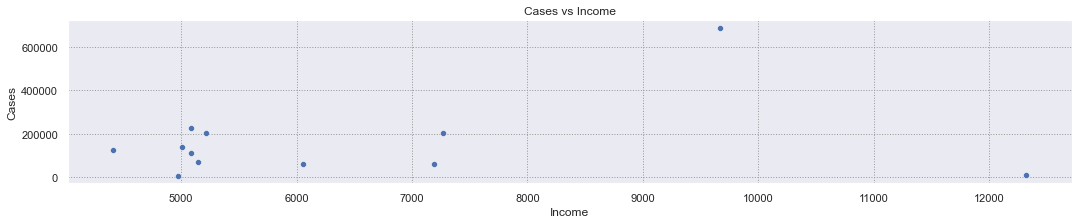

In [1165]:
# plot relationship between cases_new and income
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(x='income', y='cases_new', data=cases_income)
plt.xlabel('Income')
plt.ylabel('Cases')
plt.title('Cases vs Income')
plt.show()

With a Pearson coefficient of 0.2481, there does not appear to be a noticeable relationship between the average income of the state and the total number of cases, leading us to possibly hypothesise that the Covid contagion may not be a socio-economic one. 

### Is there any correlation between vaccination and daily cases for Selangor, Sabah, Sarawak, and many more?

In [1166]:
# prepare a generic function that calculates the cumulative sum of cases and percentage vaccinated for each state
'''
Inputs: state
Outputs: correlation matrix, dataframe of cumulative cases and percentage vaccinated
'''
def cases_vax_corr(state, mode = 1,percentage = 0):
    vax_state_temp = vax_state.copy()
    vax_state_temp = vax_state_temp[vax_state_temp['state'] == state]
    population_state = population[population['state'] == state]['pop'].iloc[0]
    vax_state_temp['cmul'] = vax_state_temp['daily_full'].cumsum()
    vax_state_temp['percentage_vaccinated'] = vax_state_temp['cmul'] / population_state

    state_cases = cases_state[cases_state['state'] == state]
    if mode == 2 :
        date = vax_state_temp[vax_state_temp['percentage_vaccinated'] >= percentage]['date'].iloc[0]
        state_cases = cases_state[cases_state['date'] >= date]
    state_vax = vax_state[vax_state['state'] == state]
    state_merged = state_cases.merge(state_vax, on='date')
    corr = state_merged[['daily', 'cases_new']].corr()
    
    return corr,vax_state_temp

In [1167]:
corr_selangor1,vax_percentage_selangor1 = cases_vax_corr('Selangor',1)
corr_selangor2,vax_percentage_selangor2 = cases_vax_corr('Selangor',2,0.05)
corr_selangor3,vax_percentage_selangor3 = cases_vax_corr('Selangor',2,0.10)
corr_selangor4,vax_percentage_selangor4 = cases_vax_corr('Selangor',2,0.15)
corr_sabah1,vax_percentage_sabah1 = cases_vax_corr('Sabah',1)
corr_sabah2,vax_percentage_sabah2 = cases_vax_corr('Sabah',2,0.05)
corr_sabah3,vax_percentage_sabah3 = cases_vax_corr('Sabah',2,0.15)
corr_sabah4,vax_percentage_sabah4 = cases_vax_corr('Sabah',2,0.2)
corr_sarawak1,vax_percentage_sarawak1= cases_vax_corr('Sarawak',1)
corr_sarawak2,vax_percentage_sarawak2= cases_vax_corr('Sarawak',2,0.05)
corr_sarawak3,vax_percentage_sarawak3= cases_vax_corr('Sarawak',2,0.15)
corr_sarawak4,vax_percentage_sarawak4= cases_vax_corr('Sarawak',2,0.2)

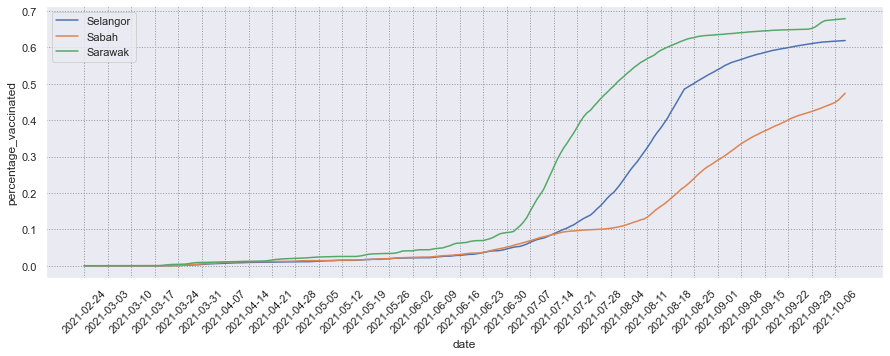

In [1168]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_selangor1, label='Selangor')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sabah1, label='Sabah')
sns.lineplot(x='date', y='percentage_vaccinated', data=vax_percentage_sarawak1, label='Sarawak')
plt.xticks([i for i in range(0, len(vax_percentage_selangor1), 7)], vax_percentage_selangor1['date'].iloc[::7], rotation=45)
plt.legend()

In [1169]:
table = {'Full Period':[corr_selangor1['daily']['cases_new'], corr_sabah1['daily']['cases_new'], corr_sarawak1['daily']['cases_new']],
        'When Vacinated Rate Over 0.05':[corr_selangor2['daily']['cases_new'], corr_sabah2['daily']['cases_new'], corr_sarawak2['daily']['cases_new']],
        'When Vacinated Rate Over 0.10':[corr_selangor3['daily']['cases_new'], corr_sabah3['daily']['cases_new'], corr_sarawak3['daily']['cases_new']],
        'When Vacinated Rate Over 0.15':[corr_selangor4['daily']['cases_new'], corr_sabah4['daily']['cases_new'], corr_sarawak4['daily']['cases_new']]}
 
# Creates pandas DataFrame.
table = pd.DataFrame(table, index =['Selangor','Sabah','Sarawak'])
table

,Full Period,When Vacinated Rate Over 0.05,When Vacinated Rate Over 0.10,When Vacinated Rate Over 0.15
Selangor,0.901396,0.036659,0.052980,0.086759
Sabah,0.870960,0.204788,0.169507,0.170766
Sarawak,-0.181897,-0.196554,-0.104347,-0.087613


The table above will show the results of the correlation value between the daily fully vaccinated and daily new cases for Selangor, Sabah, and Sarawak. The full period column shows the result from the starting date of the datasets to the latest data, and based on the result we can see that both Selangor and Sabah also have a high positive correlation value but for Sarawak is near zero. So, we added another 3 columns which show the correlation result when the vaccinated rate reaches 0.05,0.1 and 0.15. Based on the result of the columns we can see that the correlation value for all 3 states is low and near to zero. When we refer to the line graph that shows all 3 states vaccinated percentage, we can see that Sarawak has the highest vaccinated rate and its line is above Selangor and Sabah most of the time. So, it makes the Sarawak correlation value is way lower than Selangor and Sabah in the full period columns due to Sarawak starting its vaccination earlier. Hence, we can conclude that when the vaccinated rate reaches a certain point, the correlation between daily fully vaccinated and daily new cases will become close to zero.

### Which states have been most affected by Covid clusters?

To answer this question, we first split the "states" column into individual states and explode the dataframe. 

In [1170]:
# iterate row by row through clusters dataframe
import re
clusters['single_state'] = clusters['state'].apply(lambda x: [state.strip().title() for state in re.split(', | & ', x)])
clusters_singlestate = clusters.explode('single_state')
clusters_singlestate = clusters_singlestate[clusters_singlestate['single_state'].isin(['Wp Kuala Lumpur', 'Wp Putrajaya', 'Selangor', 'Negeri Sembilan', 'Pahang', 'Johor', 'Sarawak', 'Kedah', 'Perak', 'Kelantan'])]

In [1171]:
clusters_singlestate['cases_total'].describe()

count    5132.000000
mean      112.030398
std       364.416899
min         2.000000
25%        19.000000
50%        38.000000
75%        86.000000
max      7205.000000
Name: cases_total, dtype: float64

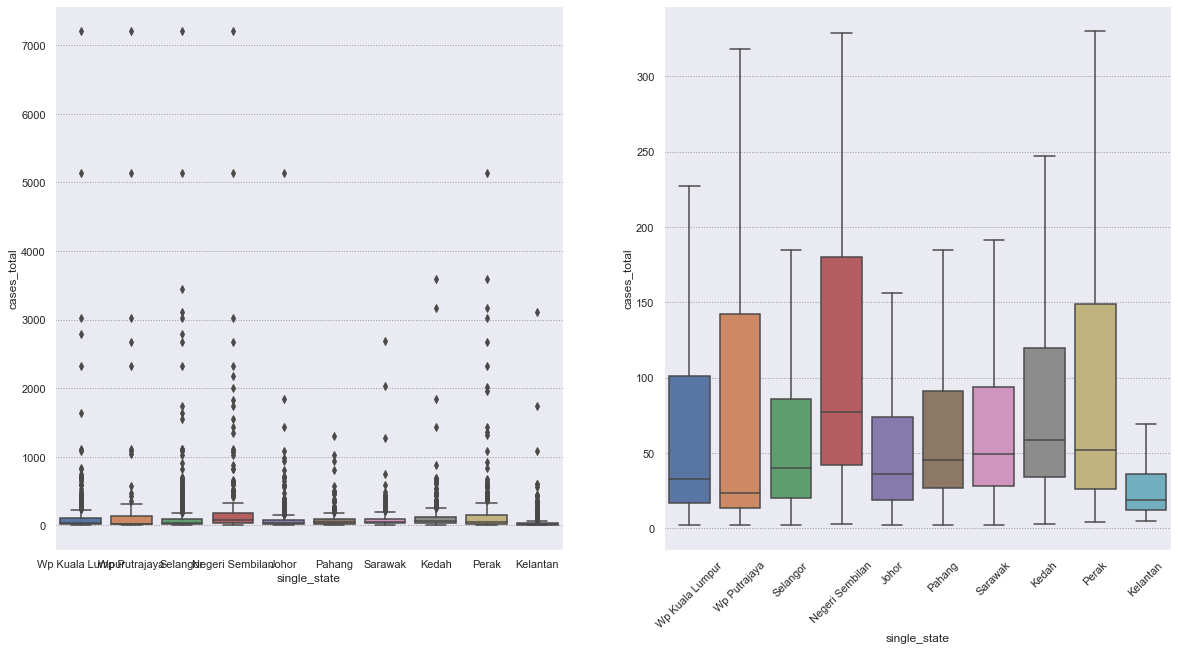

In [1172]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(rotation=45)
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, ax=ax[0])
sns.boxplot(x='single_state', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])
plt.show()

We can see from the boxplot that the majority of Covid Clusters are small, while there exists some large scale clusters in each state. In this case, to get a more meaningful idea of the drasticity of the majority of outliers, we will first remove the outliers. If we compare the boxplot with and without outliers, we can see that the majority of clusters are quite small, often under 100 cases. Just because a state is big does not mean that there are many cases that are due to Covid clusters. In this case, Negeri Sembilan seems to be the state most affected by individual clusters. Some Covid clusters also span across multiple states. 

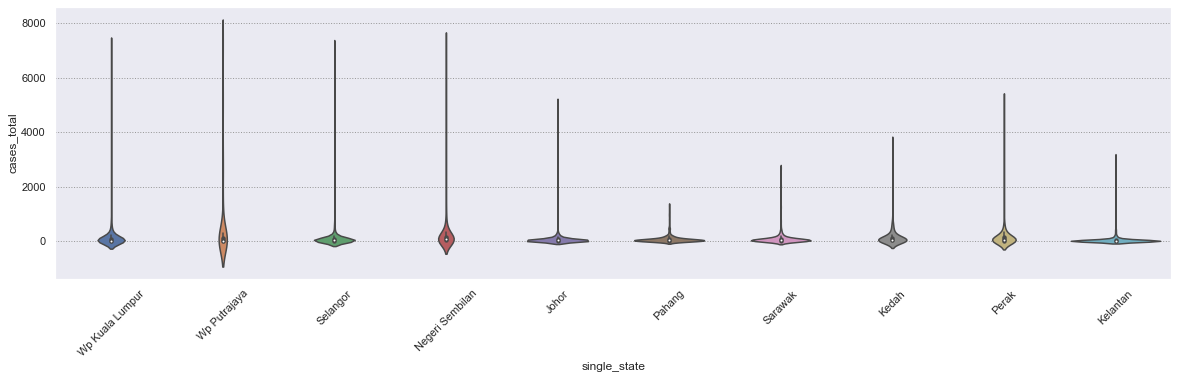

In [1173]:
plt.figure(figsize=(20, 5))
sns.violinplot(x='single_state', y='cases_total', data=clusters_singlestate)
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='category', ylabel='cases_total'>

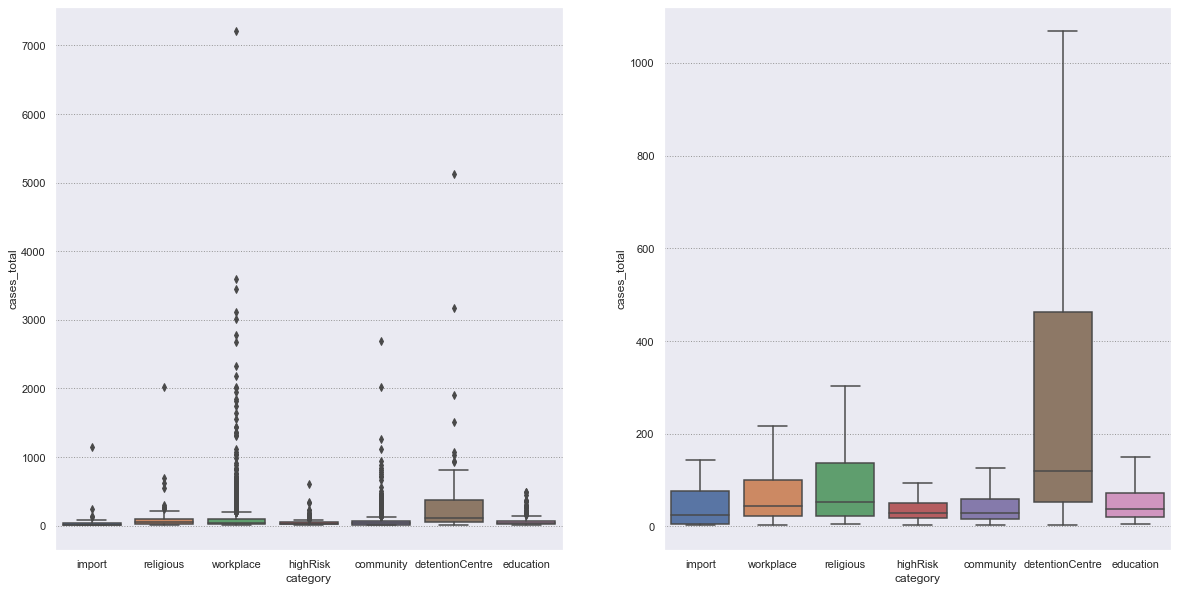

In [1174]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x='category', y='cases_total', data=clusters, ax=ax[0])
sns.boxplot(x='category', y='cases_total', data=clusters_singlestate, showfliers=False, ax=ax[1])

The detention centers generally have the largest Covid clusters, with a strong right skew. The rest of the cluster categories have mostly small clusters, but quite a few unusually large clusters. This is especially for the workplace clusters. For instance, most companies/organisations in Malaysia are small, so there may be a lot of clusters, but only some are large enought to appear as an outlier. 

### How well is Malaysia's vaccination campaign doing compared to other countries in South-East Asia?

In [1175]:
global_datasets =  pd.read_csv('./global_datasets/owid-covid-data.csv')
global_datasets

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124194,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124195,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124196,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
124197,ZWE,Africa,Zimbabwe,2021-10-15,132285.0,34.0,82.857,4655.0,0.0,3.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [1176]:
global_datasets.isna().sum()

iso_code                                        0
continent                                    5632
location                                        0
date                                            0
total_cases                                  6661
                                            ...  
human_development_index                     14348
excess_mortality_cumulative_absolute       119705
excess_mortality_cumulative                119705
excess_mortality                           119705
excess_mortality_cumulative_per_million    119705
Length: 65, dtype: int64

In [1177]:
global_datasets.fillna(0, inplace=True)
global_datasets.isna().sum()

iso_code                                   0
continent                                  0
location                                   0
date                                       0
total_cases                                0
                                          ..
human_development_index                    0
excess_mortality_cumulative_absolute       0
excess_mortality_cumulative                0
excess_mortality                           0
excess_mortality_cumulative_per_million    0
Length: 65, dtype: int64

In [1178]:
global_datasets.drop_duplicates(inplace=True)

In [1179]:
list(global_datasets.columns)

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'new_cases_smoothed',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'total_cases_per_million',
 'new_cases_per_million',
 'new_cases_smoothed_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'new_deaths_smoothed_per_million',
 'reproduction_rate',
 'icu_patients',
 'icu_patients_per_million',
 'hosp_patients',
 'hosp_patients_per_million',
 'weekly_icu_admissions',
 'weekly_icu_admissions_per_million',
 'weekly_hosp_admissions',
 'weekly_hosp_admissions_per_million',
 'new_tests',
 'total_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'positive_rate',
 'tests_per_case',
 'tests_units',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'total_vaccinations_per_hundred',
 'people_vaccinated_per_hundred',
 'peo

In [1180]:
global_datasets.drop(columns=['iso_code', 'continent','new_cases_smoothed','new_deaths_smoothed','new_cases_smoothed_per_million',
                              'new_deaths_smoothed_per_million','reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
                              'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million','weekly_hosp_admissions',
                              'weekly_hosp_admissions_per_million','new_tests_smoothed','total_boosters','new_vaccinations_smoothed',
                              'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','median_age',
                              'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','cardiovasc_death_rate','diabetes_prevalence',
                              'female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','life_expectancy','human_development_index',
                              'excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million',
                             ], inplace=True)
global_datasets.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,population,population_density
0,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.126,0.126,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
1,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
2,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
3,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422
4,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.126,0.000,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39835428.0,54.422


In [1181]:
def getCountry(country) :
    filter = global_datasets['location'] == country
    df = global_datasets[filter]
    df = df[['date','population','people_fully_vaccinated']]
    df['cumul'] = df['people_fully_vaccinated'].cumsum()
    df['percentage_vaccinated'] = df['cumul'] / df['population']
    filter2 = df['date'] > '2021-04'
    df = df[filter2]
    return df

In [1182]:
Brunei = getCountry('Brunei')
Myanmar = getCountry('Myanmar')
Cambodia = getCountry('Cambodia')
Indonesia = getCountry('Indonesia')
Laos = getCountry('Laos')
Malaysia = getCountry('Malaysia')
Philippines = getCountry('Philippines')
Singapore = getCountry('Singapore')
Thailand = getCountry('Thailand')
Vietnam = getCountry('Vietnam')

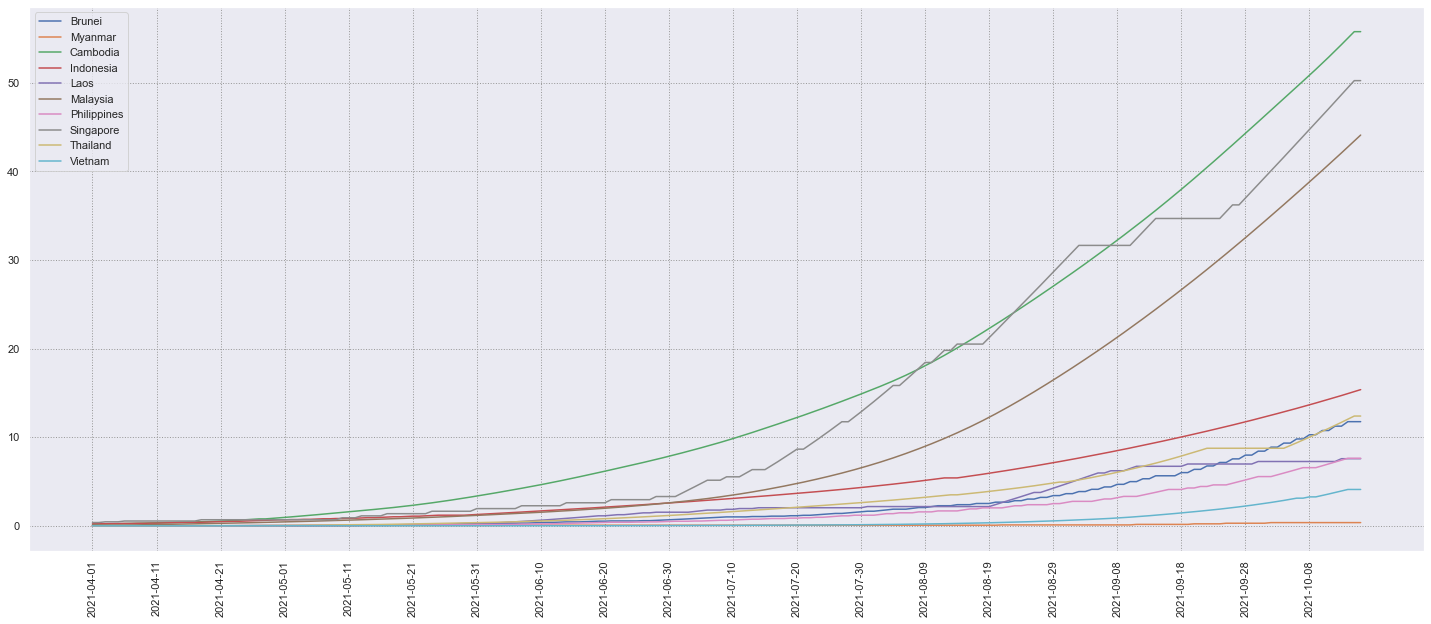

In [1183]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(Brunei['date'], Brunei['percentage_vaccinated'], label = "Brunei")
ax.plot(Myanmar['date'], Myanmar['percentage_vaccinated'], label = "Myanmar")
ax.plot(Cambodia['date'], Cambodia['percentage_vaccinated'], label = "Cambodia")
ax.plot(Indonesia['date'], Indonesia['percentage_vaccinated'], label = "Indonesia")
ax.plot(Laos['date'], Laos['percentage_vaccinated'], label = "Laos")
ax.plot(Malaysia['date'], Malaysia['percentage_vaccinated'], label = "Malaysia")
ax.plot(Philippines['date'], Philippines['percentage_vaccinated'], label = "Philippines")
ax.plot(Singapore['date'], Singapore['percentage_vaccinated'], label = "Singapore")
ax.plot(Thailand['date'], Thailand['percentage_vaccinated'], label = "Thailand")
ax.plot(Vietnam['date'], Vietnam['percentage_vaccinated'], label = "Vietnam")
ax.set_xticks(ax.get_xticks()[::10])
ax.tick_params(axis='x', labelrotation=90)
ax.legend()

The line graph above shows that the vaccination rate for each country in South-East Asia. Based on the result, we can see that Cambodia has the highest vaccinated rate compared to other countries and Myanmar have the lowest vaccinated rate which is near zero. For Malaysia, we ranked top 3 in the graph and the vaccinated rate is near 45%. Hence, we can conclude that Malaysia's vaccination campaign is doing better than the majority of South-East Asia's countries.

### Is there a link between traces_malaysia casual_contacts and daily cases? Can we classify how contagious Covid is?

In [1184]:
trace_malaysia = pd.read_csv('./cases/mysejahtera/trace_malaysia.csv')
trace_malaysia

,date,casual_contacts,hide_large,hide_small
0,2021-03-01,7847,NaN,NaN
1,2021-03-02,6419,NaN,NaN
2,2021-03-03,6903,NaN,NaN
3,2021-03-04,7000,NaN,NaN
4,2021-03-05,9152,NaN,NaN
...,...,...,...,...
216,2021-10-03,32301,37.0,604.0
217,2021-10-05,37312,39.0,841.0
218,2021-10-06,34444,45.0,782.0
219,2021-10-07,39312,43.0,820.0


In [1185]:
trace_malaysia.isna().sum()

date                0
casual_contacts     0
hide_large         50
hide_small         50
dtype: int64

In [1186]:
trace_malaysia.fillna(0,inplace=True)

In [1187]:
trace_malaysia.drop_duplicates(inplace=True)

In [1188]:
temp_cases_malaysia = cases_malaysia.copy()
temp_trace_malaysia = trace_malaysia.copy()

In [1189]:
merged = temp_cases_malaysia.merge(temp_trace_malaysia, on='date')
corr = merged[['casual_contacts', 'cases_new']].corr()
corr

,casual_contacts,cases_new
casual_contacts,1.000000,0.761866
cases_new,0.761866,1.000000


<AxesSubplot:>

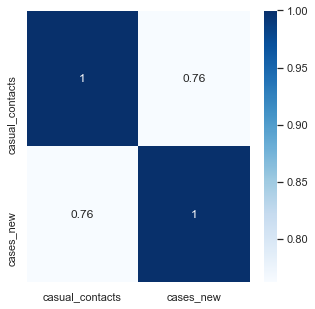

In [1190]:
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True,cmap='Blues')

Based on the heatmap result, we can see that case_new is highly correlated with casual_contacts so I mean that there is a link between the cases_new and casual_contact. Hence, we can conclude that covid-19 is a highly contagious virus.

### How has the vaccination rate changed over time across states?

##### We first obtain a new dataframe which only contains the date and the cummulative vaccination head count then we examine their correlation and visualize it using heatmap.

In [1191]:
vax_malaysia

,date,daily_partial,daily_full,daily,daily_full_child,cumul
0,2021-02-24,60,0,60,0,0
1,2021-02-25,1146,0,1146,0,0
2,2021-02-26,4115,1,4116,0,1
3,2021-02-27,6723,1,6724,0,2
4,2021-02-28,6699,3,6702,0,5
...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,6278,20819254
224,2021-10-06,113441,96466,209907,8750,20915720
225,2021-10-07,108092,88555,196647,18786,21004275
226,2021-10-08,74199,100621,174820,29091,21104896


In [1192]:
corr_vaccine = vax_malaysia[['date','cumul']]
corr_vaccine

,date,cumul
0,2021-02-24,0
1,2021-02-25,0
2,2021-02-26,1
3,2021-02-27,2
4,2021-02-28,5
...,...,...
223,2021-10-05,20819254
224,2021-10-06,20915720
225,2021-10-07,21004275
226,2021-10-08,21104896


In [1193]:
malaysia_cases = cases_state[['date','state','cases_new']]
filtered_my_cases = malaysia_cases.groupby('date').sum().reset_index()
merged_data_frame = pd.merge(filtered_my_cases, corr_vaccine, on=['date'])
corr_merged_data_frame = merged_data_frame.corr()
corr_merged_data_frame

,cases_new,cumul
cases_new,1.000000,0.757276
cumul,0.757276,1.000000


<AxesSubplot:>

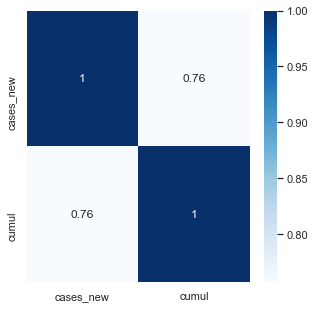

In [1194]:
plt.figure(figsize=(5,5))
sns.heatmap(corr_merged_data_frame, annot=True,cmap='Blues')

From the heat map and the correlation map we can see that the daily new cases positively correlate to each other. We plan to see the daily cases in each state but the result here is too confusing as we have 14 states. Hence we decided to plot out the graph individually to see the effect of the vaccine.

In [1195]:
grouped_malaysia_cases = malaysia_cases.groupby(['date','state']).sum().reset_index()

grouped_malaysia_cases.head()
#fig, ax = plt.subplots(figsize=(15,7))
#grouped = malaysia_cases.groupby(['date','state']).sum().unstack().plot(ax=ax)

,date,state,cases_new
0,2020-01-25,Johor,4
1,2020-01-25,Kedah,0
2,2020-01-25,Kelantan,0
3,2020-01-25,Melaka,0
4,2020-01-25,Negeri Sembilan,0


In [1196]:
vax_state = vax_state[['date','state','daily_full']]
merged_vax_state = pd.merge(vax_state, malaysia_cases, on=['date','state'])
merged_vax_state

,date,state,daily_full,cases_new
0,2021-02-24,Johor,0,318
1,2021-02-24,Kedah,0,17
2,2021-02-24,Kelantan,0,53
3,2021-02-24,Melaka,0,26
4,2021-02-24,Negeri Sembilan,0,1392
...,...,...,...,...
3643,2021-10-09,Selangor,3877,1351
3644,2021-10-09,Terengganu,3711,590
3645,2021-10-09,W.P. Kuala Lumpur,1119,288
3646,2021-10-09,W.P. Labuan,414,1


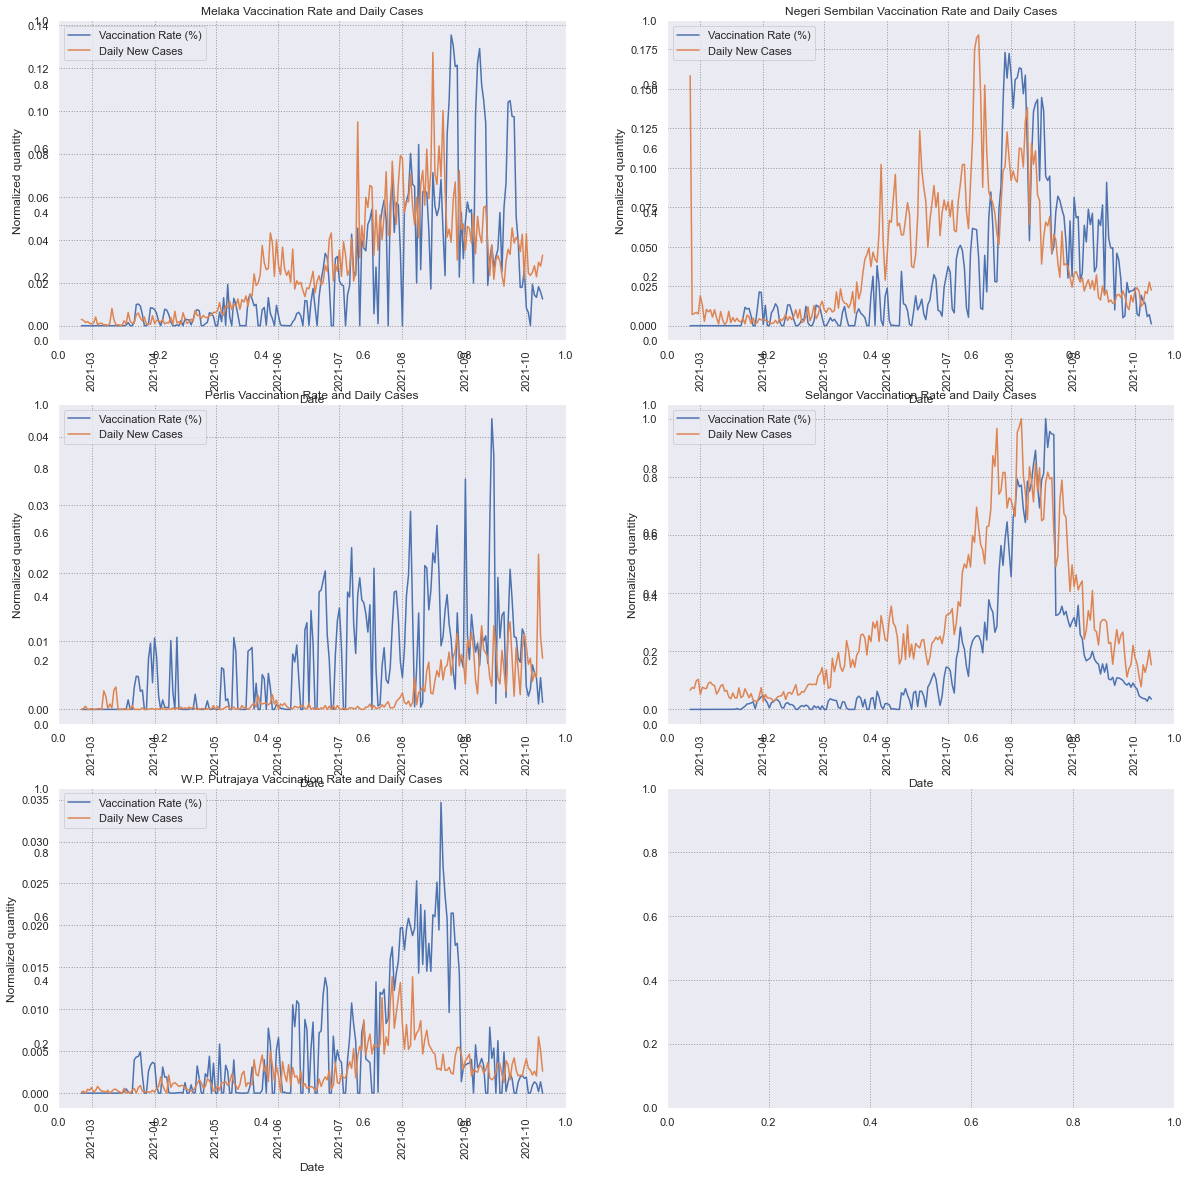

In [1197]:
from sklearn import preprocessing
import matplotlib.pyplot as plt

#states = ['Johor','Kedah','Kelantan','Melaka','Negeri Sembilan','Pahang','Perak','Perlis','Pulau Pinang','Sabah',
#          'Sarawak','Selangor','Terengganu','W.P. Kuala Lumpur','W.P. Labuan','W.P. Putrajaya']

states = ['Melaka','Negeri Sembilan','Perlis','Selangor','W.P. Putrajaya']

scaler = preprocessing.MinMaxScaler()
names = ['cases_new','daily_full']
d = scaler.fit_transform(merged_vax_state[['cases_new','daily_full']])
scaled_df = pd.DataFrame(d, columns=names)
scaled_df['date'] = pd.to_datetime(merged_vax_state['date'])
scaled_df['state'] = merged_vax_state['state']

fig, axes = plt.subplots(3, 2, figsize=(20,20))

#scaled_df[scaled_df['state']==i]['date'],
for index, i in enumerate(states):
    ax = fig.add_subplot(3, 2, index + 1)
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['daily_full'],label = "Vaccination Rate (%)")
    ax.plot(scaled_df[scaled_df['state']==i]['date'],scaled_df[scaled_df['state']==i]['cases_new'],label = "Daily New Cases")
    plt.xticks(rotation=90)
    plt.title(i + ' Vaccination Rate and Daily Cases')
    plt.xlabel('Date')
    plt.ylabel('Normalized quantity')
    leg = plt.legend(loc='upper left')

plt.show()

We first normalize both the vaccination rate(%) and the daily new cases of covid cases to see if there's any effect of vaccination. We specifically look at the top 5 states that require more attention( Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya) that we found out that have low vaccination rate in the earlier finding. As we can see from the line graph that we plot out, it is clear that when the government put more effort into getting the people vaccinated in that certain state, the daily cases would start to decline, except for Perlis. Perlis's daily cases spikes up a little in October 2021 but not drastically. We can safely assume that vaccination actually in a way help controlling the cluster cases in Perlis without going higher. Regardless, we can conclude that vaccination might be one of the contributing factor to reduce daily covid cases in Malaysia. However, more research is needed in order to conclude this finding. 

### How has the vaccination rate changed across the nation?

#### We make a new dataframe to store the cumulative population that have already get their full vaccination then, and a new column to store the percentage of the population which is derrived from the cumulative population. Lastly we plot out a line graph to visualize the vaccination rate across the whole Malaysia

In [1198]:
vax_pop_percentage = vax_malaysia['cumul']
vax_pop_percentage = pd.DataFrame(vax_pop_percentage)
vax_pop_percentage['percentage'] = vax_pop_percentage.apply(lambda x: (vax_malaysia['cumul']/population[population['state']=='Malaysia']['pop'].item())*100,axis=0)
vax_pop_percentage['date'] = pd.to_datetime(vax_malaysia['date'])
vax_pop_percentage

,cumul,percentage,date
0,0,0.000000,2021-02-24
1,0,0.000000,2021-02-25
2,1,0.000003,2021-02-26
3,2,0.000006,2021-02-27
4,5,0.000015,2021-02-28
...,...,...,...
223,20819254,63.750495,2021-10-05
224,20915720,64.045882,2021-10-06
225,21004275,64.317046,2021-10-07
226,21104896,64.625157,2021-10-08


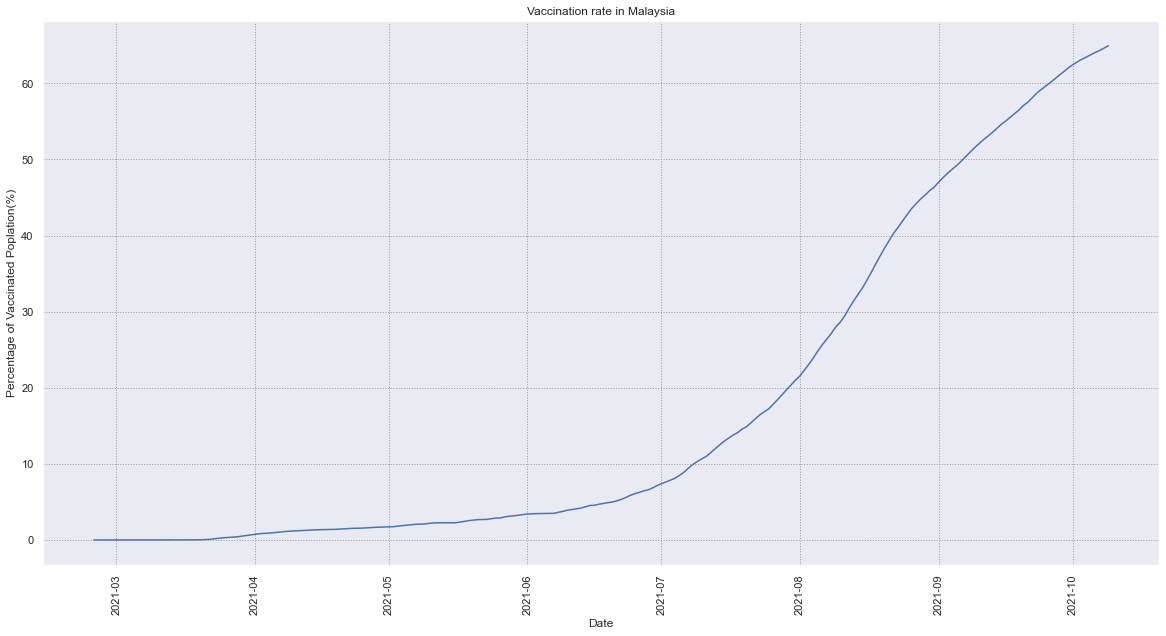

In [1199]:
import matplotlib.pyplot as plt

vax_malaysia

plt.figure(figsize=(20,10))
plt.plot(vax_pop_percentage['date'],vax_pop_percentage['percentage'])
plt.xticks(rotation=90)
plt.title('Vaccination rate in Malaysia')
plt.xlabel('Date')
plt.ylabel('Percentage of Vaccinated Poplation(%)')
plt.show()

### Which vaccines have been used the most?

In [1200]:
vax_malaysia_all_attributes

,date,daily_partial,daily_full,daily,daily_partial_child,daily_full_child,cumul_partial,cumul_full,cumul,cumul_partial_child,...,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending,pfizer,astra,sinovac
0,2021-02-24,60,0,60,0,0,60,0,60,0,...,0,0,0,0,0,0,0,60,0,0
1,2021-02-25,1146,0,1146,0,0,1206,0,1206,0,...,0,0,0,0,0,0,0,1146,0,0
2,2021-02-26,4115,1,4116,0,0,5321,1,5322,0,...,1,0,0,0,0,0,0,4116,0,0
3,2021-02-27,6723,1,6724,0,0,12044,2,12046,0,...,1,0,0,0,0,0,0,6724,0,0
4,2021-02-28,6699,3,6702,0,0,18743,5,18748,0,...,3,0,0,0,0,0,0,6702,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2021-10-05,122153,101881,224034,105150,6278,24085144,20819254,44797925,1967549,...,59655,2440,13395,130,26496,1828,767,178978,26626,15835
224,2021-10-06,113441,96466,209907,97575,8750,24200366,20915720,45007832,2065124,...,60903,2253,9424,142,24004,1781,3588,168715,24146,11677
225,2021-10-07,108092,88555,196647,91222,18786,24309648,21004275,45204479,2156346,...,54553,2651,7811,18,24482,1190,1396,159099,24500,10462
226,2021-10-08,74199,100621,174820,61574,29091,24384831,21104896,45379299,2217920,...,66510,2833,8064,26,24147,984,1227,137539,24173,10897


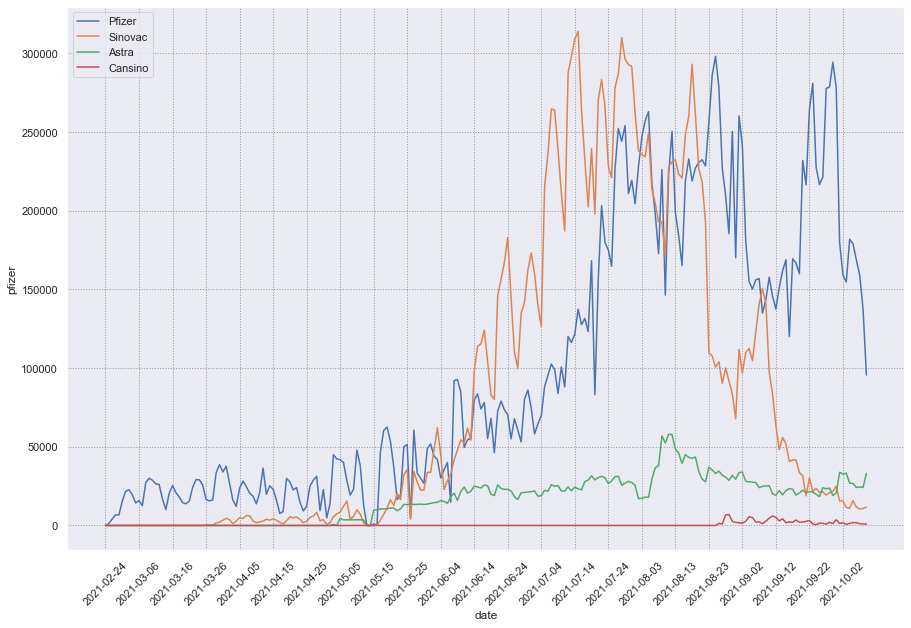

In [1201]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='date', y='pfizer', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='sinovac', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='astra', data=vax_malaysia_all_attributes)
sns.lineplot(x='date', y='cansino', data=vax_malaysia_all_attributes)
# only show some xtick labels
plt.xticks([date for i, date in enumerate(vax_malaysia_all_attributes['date']) if i % 10 == 0], rotation=45)
plt.legend(['Pfizer', 'Sinovac', 'Astra', 'Cansino'])
plt.show()

In [1202]:
vaccine_totals = pd.DataFrame(vax_malaysia_all_attributes[['pfizer', 'astra', 'sinovac']].sum().reset_index())
vaccine_totals.columns = ['vaccine', 'total']
vaccine_totals

,vaccine,total
0,pfizer,22755674
1,astra,3714440
2,sinovac,18737007


<AxesSubplot:xlabel='vaccine', ylabel='total'>

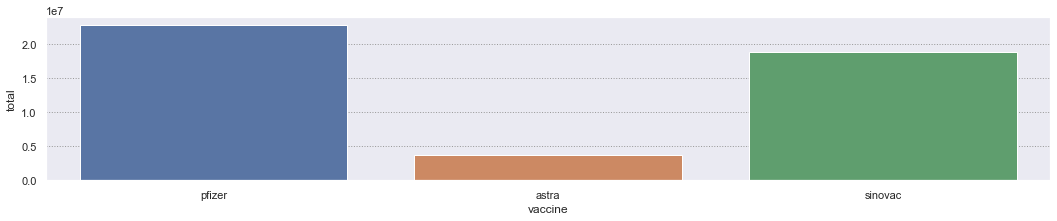

In [1203]:
sns.barplot(x='vaccine', y='total', data=vaccine_totals)

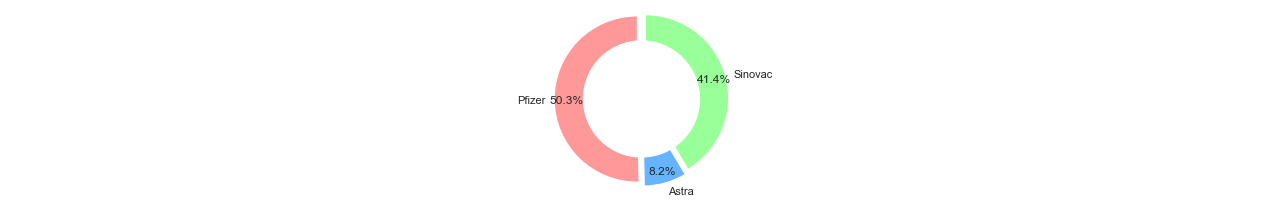

In [1204]:
# pie chart of vaccine_totals

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.05, 0.05, 0.05)
fig1, ax1 = plt.subplots()
ax1.pie(vaccine_totals['total'], labels=vaccine_totals['vaccine'].str.title(), colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.show()

Pfizer is the most used vaccine in Malaysia, followed by Sinovac and then Astrazeneca. If you observe the usage of Astrazeneca, it flails in comparison to the other two because it was opened up for voluntary registrations. Furthermore, unlike Pfizer and Sinovac, Astrazeneca usage does not show an upward trend and only has a few spikes, which may be attributed to the government opening up registrations.


## Clustering

### Do the performance of states based on cases, deaths and vaccinations form any clusters?

To answer this question, we will try several types of clustering:
* 3-dimensional clustering between cases, deaths and vaccinations treating each point on the graph as a state
    * K-Means 
* 2-dimensional clustering between cases and deaths
    * K-Means
    * DBSCAN
    * Agglomerative Clustering

We use Standard Scaler to scale the data before performing all clustering.

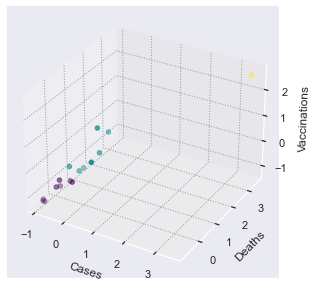

In [1205]:
states = list(cases_state['state'].unique())

cases = []
vaccinations = []
deaths = []

for state in states:
    cases.append(cases_state[cases_state['state'] == state]['cases_new'].sum())
    deaths.append(deaths_state[deaths_state['state'] == state]['deaths_new'].sum())
    vaccinations.append(vax_state[deaths_state['state'] == state]['daily_full'].sum())

cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
for col in cases_deaths_vaccinations:
    if cases_deaths_vaccinations[col].dtype != 'object':
        cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

states_column = cases_deaths_vaccinations['state']
cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
X_std = cases_deaths_vaccinations

km = KMeans(n_clusters=3, max_iter=100)
y_clusters = km.fit_predict(cases_deaths_vaccinations)
centroids = km.cluster_centers_

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
ax.set_xlabel('Cases')
ax.set_ylabel('Deaths')
ax.set_zlabel('Vaccinations')
plt.show()

In [1206]:
cases_deaths_vaccinations['predictions'] = y_clusters
cases_deaths_vaccinations['state'] = states_column
cases_deaths_vaccinations

,cases,deaths,vaccinations,predictions,state
0,0.376115,0.779508,1.018159,1,Johor
1,-0.036383,0.087040,-0.094470,1,Kedah
2,-0.135631,-0.370070,-0.402749,0,Kelantan
3,-0.543889,-0.380046,-0.695190,0,Melaka
4,-0.299397,-0.226769,-0.504680,0,Negeri Sembilan
5,-0.483369,-0.496591,-0.367193,0,Pahang
6,-0.237798,-0.338326,0.152994,1,Perak
7,-0.901673,-0.733309,-1.121005,0,Perlis
8,-0.060205,-0.110678,-0.100764,1,Pulau Pinang
9,0.378025,0.287026,0.510771,1,Sabah


The 3-dimensional graph is quite hard to interpret, but we can observe 3 main clusters forming, which are:
1. Low cases and low deaths
2. Low cases and High deaths
3. High cases, High deaths and High vaccinations

With no surprise, the third cluster with high cases, deaths and vaccination rates is Selangor.

To get better insights, we remove the third dimension (vaccinations) temporarily and cluster only based on cases and deaths.

### How did the clusters change over time with respect to cases, deaths and vaccinations? Did some states reorganise into new clusters?

In this question, we bring in a third factor: vaccinations.

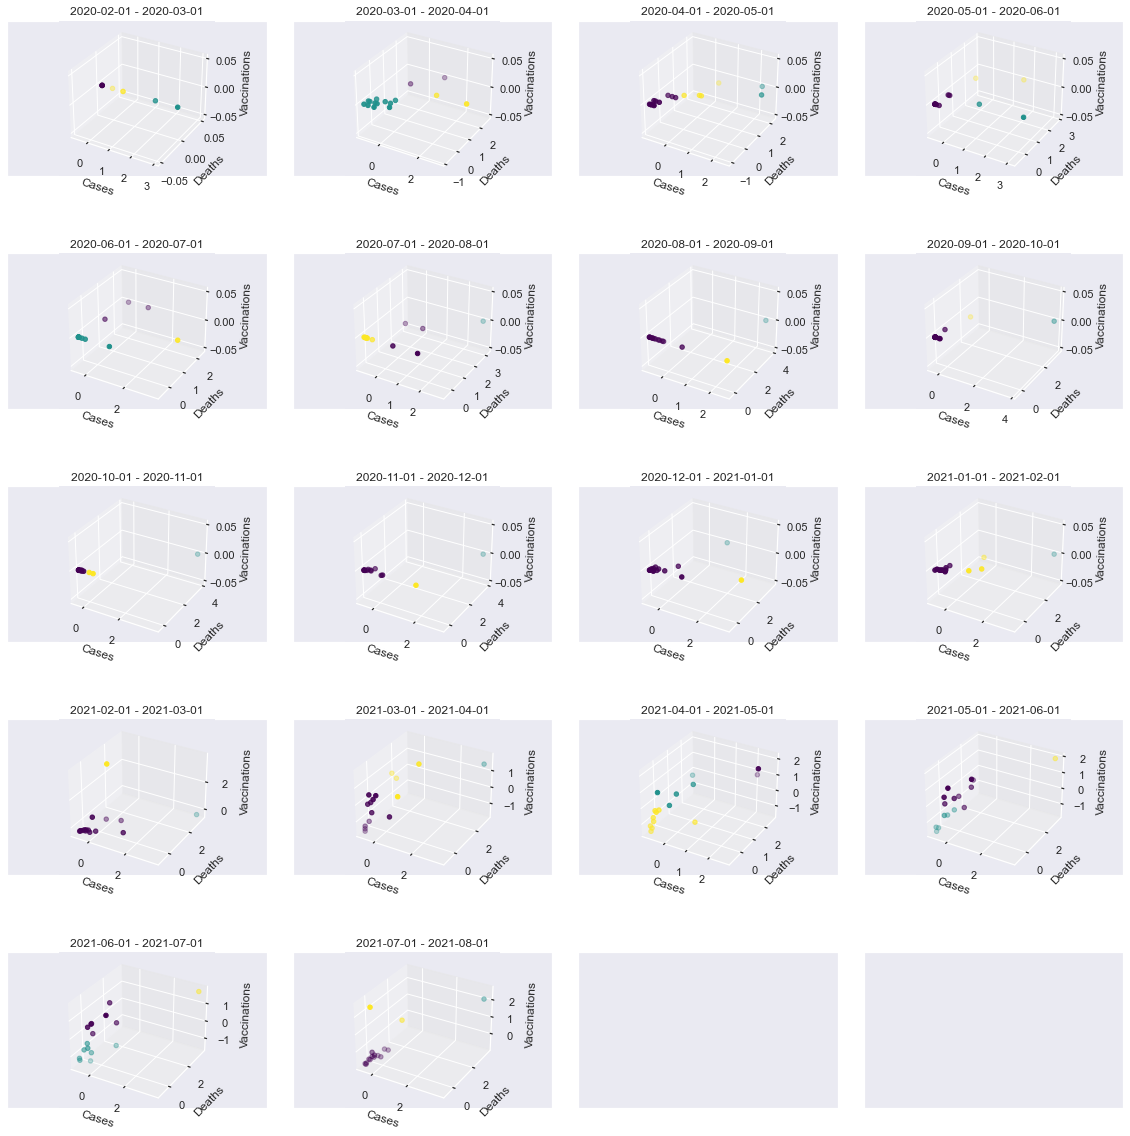

In [1207]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] >= date_range[0]) & (vax_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())
        vaccinations.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths, "vaccinations": vaccinations})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations
    
    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num, projection='3d')
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], cases_deaths_vaccinations['vaccinations'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_zlabel('Vaccinations')
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

We maintain that states can be grouped into 3 clusters. Throughout 2020, vaccinations are 0 and hence, the clusters slowly start to expand in terms of cases and deaths. By 2021, the states have spread reasonably wide throughout the 3 dimensions. By early 2021, cases and deaths are at an all time high. Around this time, vaccination begins and clusters start moving higher in that dimension. However, even in September, there is one cluster of states with relatively low vaccinations.

### How did the clusters change over time with respect to cases and deaths alone? Did some states reorganise into new clusters?

#### KMeans

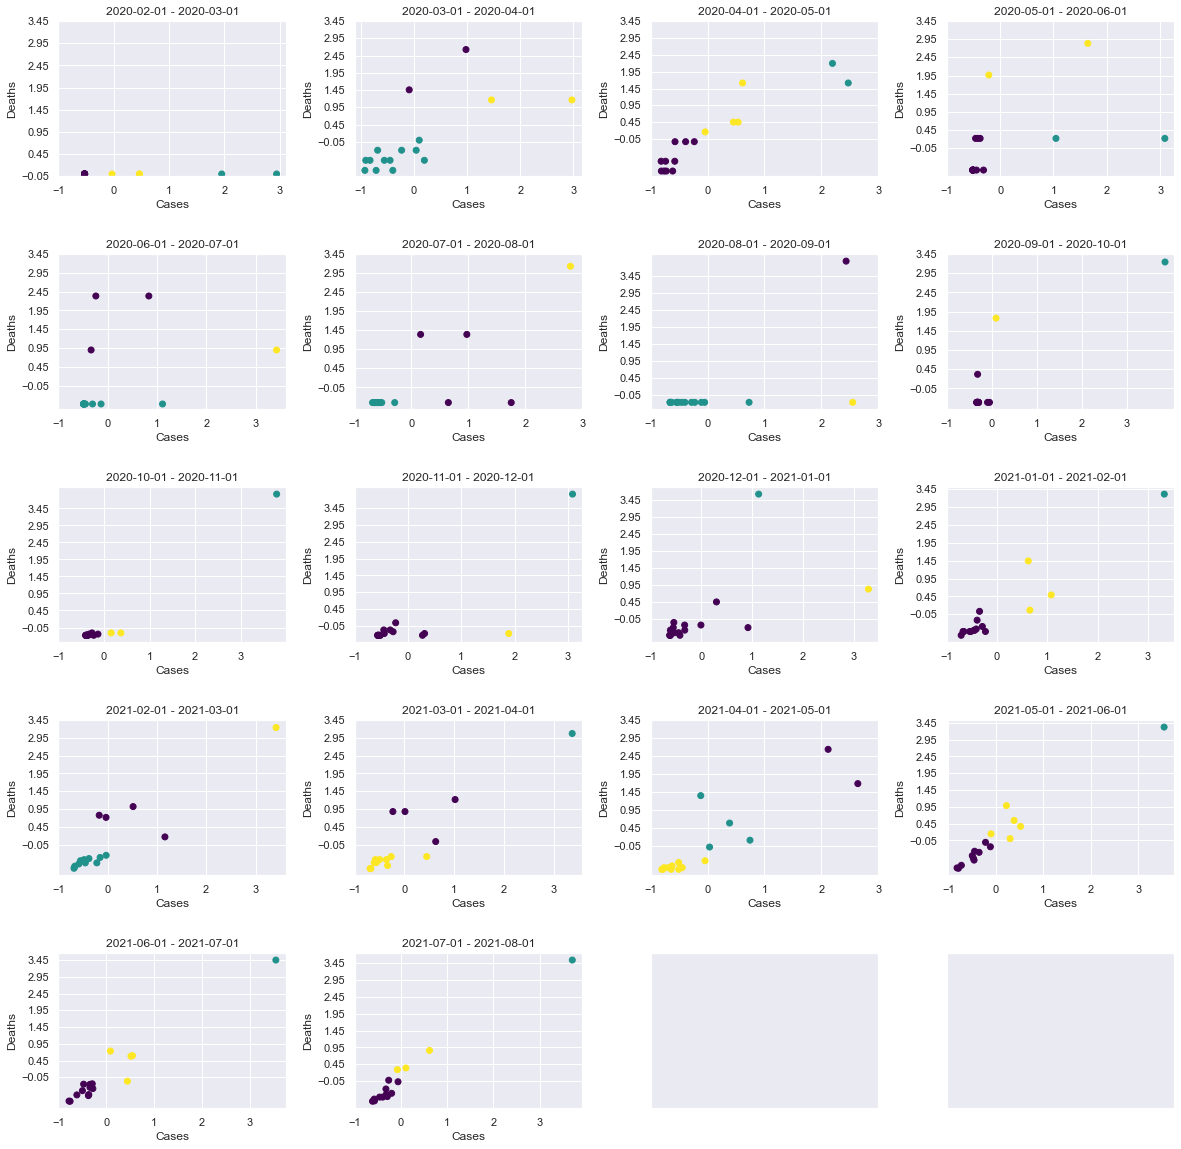

In [1208]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_xticks(np.arange(-1, 4, 1))
    ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

#### DBSCAN

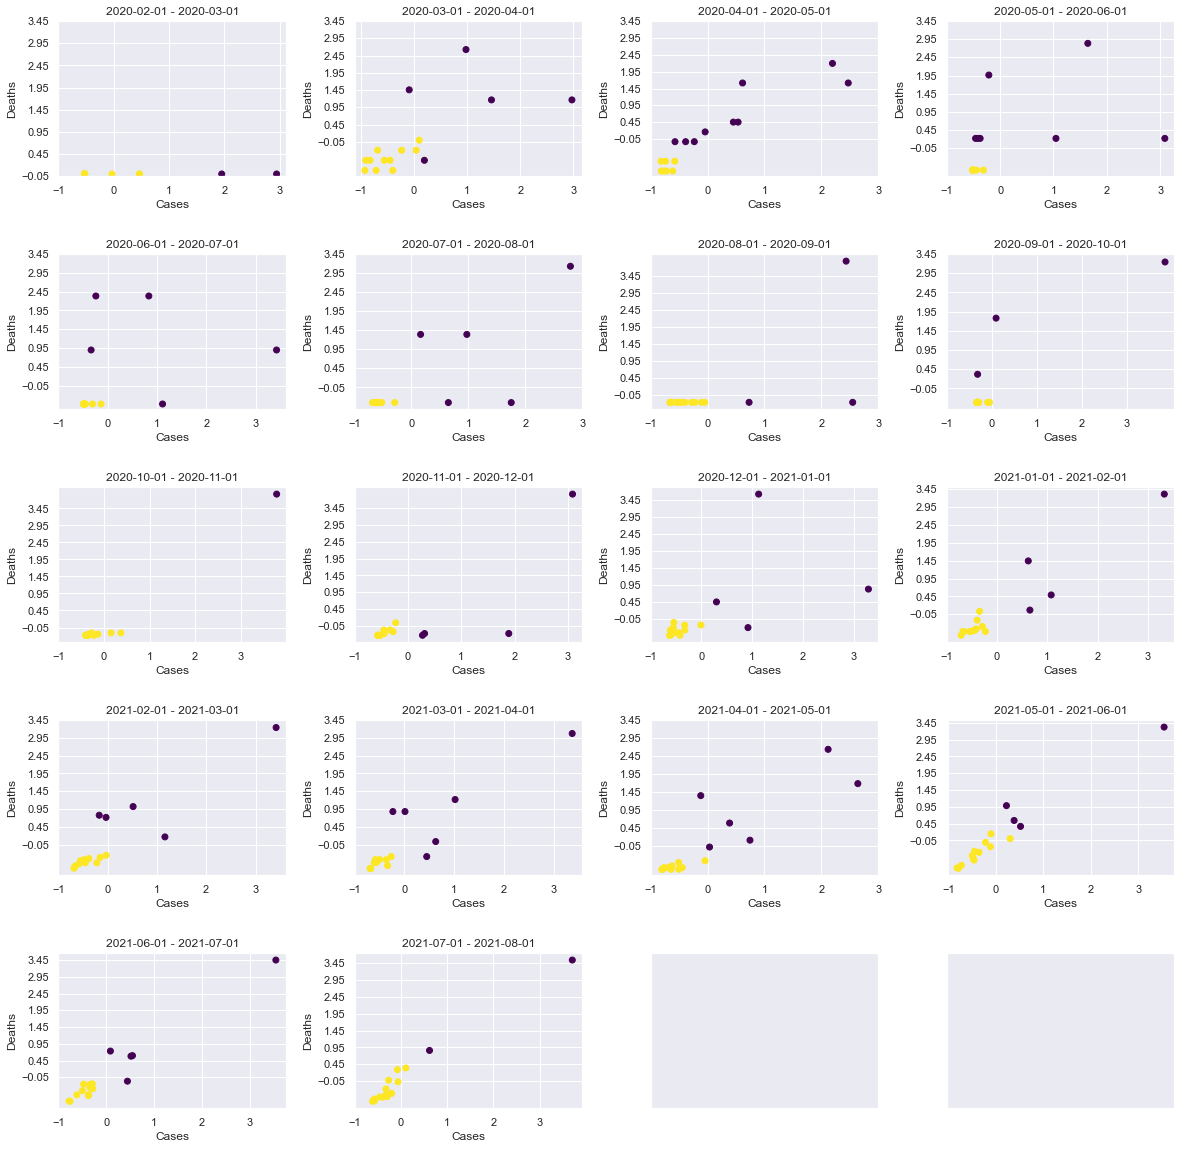

In [1209]:
nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    dbscan = DBSCAN(eps=0.5, min_samples=5).fit(cases_deaths_vaccinations)
    y_clusters = dbscan.fit_predict(cases_deaths_vaccinations)

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
    ax.set_xticks(np.arange(-1, 4, 1))
    ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

#### Agglomerative Clustering

In [1210]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(mod, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(mod.children_.shape[0])
    n_samples = len(mod.labels_)
    for i, merge in enumerate(mod.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([mod.children_, mod.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


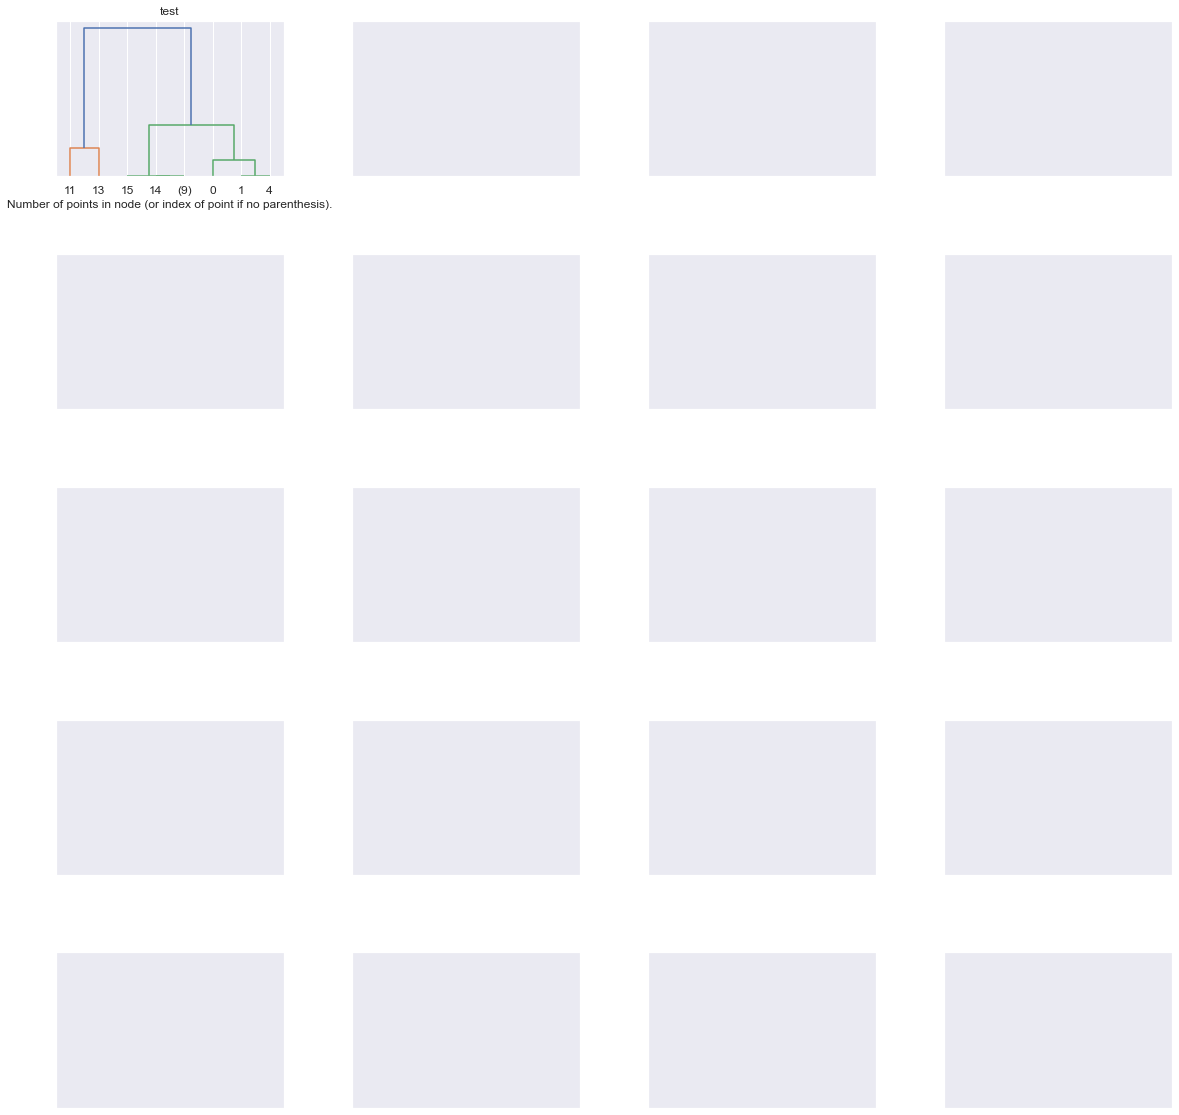

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


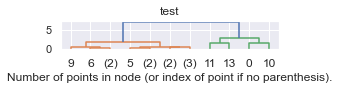

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


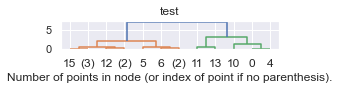

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


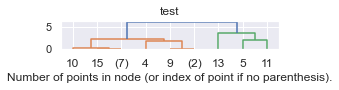

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


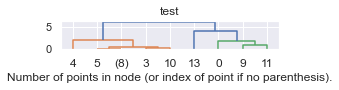

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


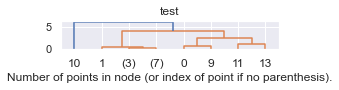

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


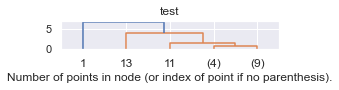

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


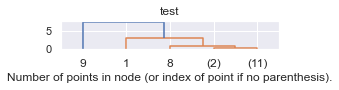

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


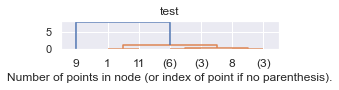

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


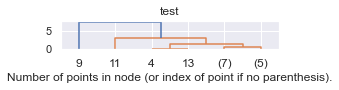

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


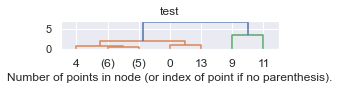

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


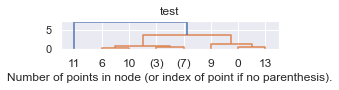

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


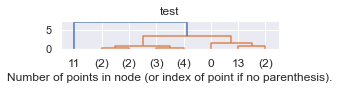

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


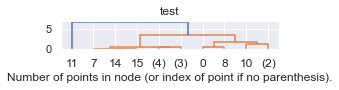

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


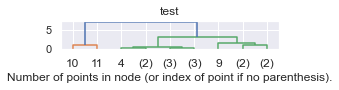

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


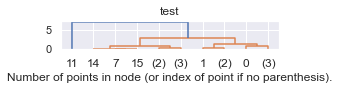

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


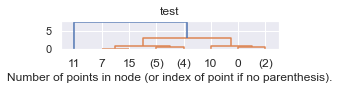

<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>


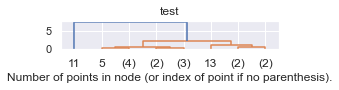

In [1211]:
from sklearn.cluster import AgglomerativeClustering

nrows = 5
ncols = 4
fig, axes = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    
    cases = []
    vaccinations = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum())

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "cases": cases, "deaths": deaths})
    for col in cases_deaths_vaccinations:
        if cases_deaths_vaccinations[col].dtype != 'object':
            cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    agg = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    agg = agg.fit(cases_deaths_vaccinations)
    print(type(agg))

    # plot agglomerative clustering
    plt.subplot(nrows, ncols, i+1)
    plt.title('test')
    plot_dendrogram(agg, truncate_mode='level', p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

    # row, col, num = grid_combos[i]

    # ax = fig.add_subplot(row, col, num)
    # ax.scatter(cases_deaths_vaccinations['cases'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    # ax.set_xlabel('Cases')
    # ax.set_ylabel('Deaths')
    # ax.set_xticks(np.arange(-1, 4, 1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    # ax.set_title(f"{date_range[0]} - {date_range[1]}")

We can observe that in the beginning, the majority of the clusters were positioned towards the bottom left and they maintain a similar pattern until about August 2020. In August, the cases were still high but there were fewer deaths, which may signify that the situation was improving, besides the one state that is in the upper corner of the plot that stands out from the rest. Around December, the bottom-right cluster begins to break up and states start moving diagonally upwards in the graph, meaning higher number of deaths and more cases. By September 2021, the states fall in a sort of straight diagonal line, with the performance of states spread across the spectrum from mild to serious. 

We also set out to find that one state that created a cluster of it's own throughout and it was Selangor, to no one's surprise.

### Which states require attention in terms of their vaccination campaign and deaths?

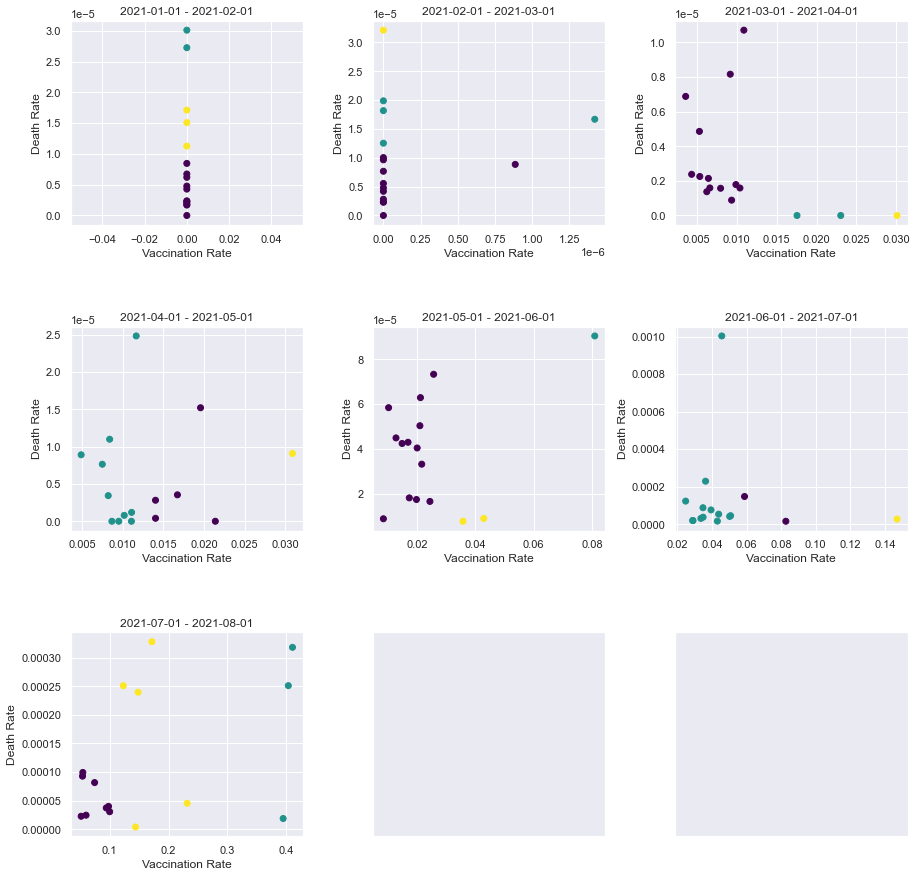

In [1212]:
sns.set(rc={'figure.figsize':(18, 3)})
nrows = 3
ncols = 3
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
fig.set_visible(True)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid_combos = []
for i in range(1, 20):
    grid_combos.append((nrows, ncols, i))

dates = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
ranges = [(dates[i], dates[i+1]) for i in range(len(dates)-1)]

for i, date_range in enumerate(ranges):
    cases_state_date = cases_state[(cases_state['date'] >= date_range[0]) & (cases_state['date'] < date_range[1])]
    deaths_state_date = deaths_state[(deaths_state['date'] >= date_range[0]) & (deaths_state['date'] < date_range[1])]
    vax_state_date = vax_state[(vax_state['date'] >= date_range[0]) & (vax_state['date'] < date_range[1])]

    cases = []
    vaccination_rates = []
    deaths = []

    for state in states:
        cases.append(cases_state_date[cases_state_date['state'] == state]['cases_new'].sum())
        deaths.append(deaths_state_date[deaths_state_date['state'] == state]['deaths_new'].sum() / population.loc[population['state'] == state, 'pop'].values[0])
        # divide number of vaccinations by state population
        vaccination_rates.append(vax_state_date[vax_state_date['state'] == state]['daily_full'].sum() / population.loc[population['state'] == state, 'pop'].values[0])

    cases_deaths_vaccinations = pd.DataFrame({"state": states, "deaths": deaths, "vaccination_rate": vaccination_rates})
    # for col in cases_deaths_vaccinations:
    #     if cases_deaths_vaccinations[col].dtype != 'object':
    #         cases_deaths_vaccinations[col] = StandardScaler().fit_transform(cases_deaths_vaccinations[[col]])

    cases_deaths_vaccinations.drop(columns=['state'], inplace=True)
    X_std = cases_deaths_vaccinations

    km = KMeans(n_clusters=3, max_iter=100)
    y_clusters = km.fit_predict(cases_deaths_vaccinations)
    centroids = km.cluster_centers_

    # put back state column
    cases_deaths_vaccinations['state'] = states

    row, col, num = grid_combos[i]

    ax = fig.add_subplot(row, col, num)
    ax.scatter(cases_deaths_vaccinations['vaccination_rate'], cases_deaths_vaccinations['deaths'], c=y_clusters, cmap='viridis')
    ax.set_xlabel('Vaccination Rate')
    ax.set_ylabel('Death Rate')
    # ax.set_xticks(np.arange(-0.5, 0.5, 0.1))
    # ax.set_yticks(np.arange(-0.05, 3.5, 0.5))
    ax.set_title(f"{date_range[0]} - {date_range[1]}")

In [1213]:
cases_deaths_vaccinations[y_clusters == 1]

,deaths,vaccination_rate,state
10,0.000019,0.394775,Sarawak
13,0.000318,0.410651,W.P. Kuala Lumpur
14,0.000251,0.403524,W.P. Labuan


We can see that throughout 2020, there are 0 vaccinations in all state since the vaccination campaign was yet to start. By February 2021, two states have begun their vaccination campaigns. It speeds up more rapidly by March and April, the vertical clusters start to spread out on the x-axis indicating higher vaccination numbers. In June 2021, there was a remarkable shoot where the y-axis scale completely changed. As of September 2021, the states that may require attention are those with low vaccination rates and high deaths, namely cluster 2, which contains the following states:
1. Melaka
2. Negeri Sembilan
3. Perlis
4. Selangor
5. W.P. Putrajaya

On the other hand, these are the states with relatively high vaccination rates w.r.t deaths:
1. Sarawak
2. W.P. Kuala Lumpur
3. W.P. Labuan

## Regression

### Does the current vaccination rate allow herd immunity to be achieved by 30 November 2021? You can assume that herd immunity can be achieved with 80% of the population having been vaccinated. (pending) (need time series)

In [1214]:
# vax_population = vax_malaysia.merge(population, on='state')
malaysia_population = population[population['state'] == 'Malaysia']['pop'].iloc[0]
vax_malaysia['cumul'] = vax_malaysia['daily_full'].cumsum()
vax_malaysia['percentage_vaccinated'] = vax_malaysia['cumul'] / malaysia_population

<AxesSubplot:xlabel='date'>

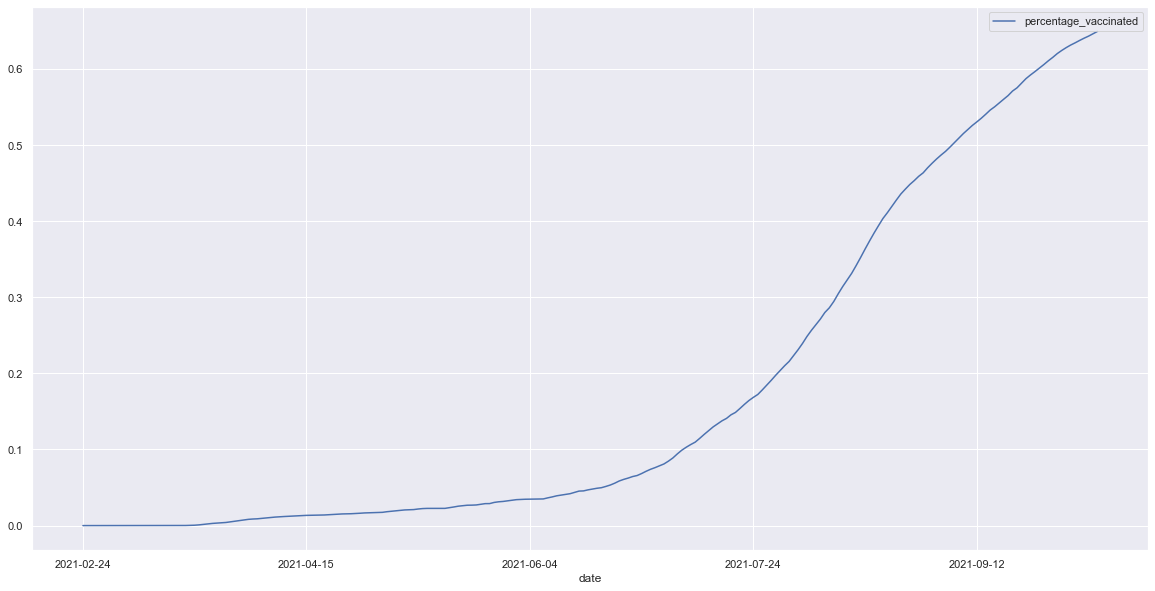

In [1215]:
vax_malaysia.plot.line(x='date', y='percentage_vaccinated', figsize=(20,10))

<AxesSubplot:>

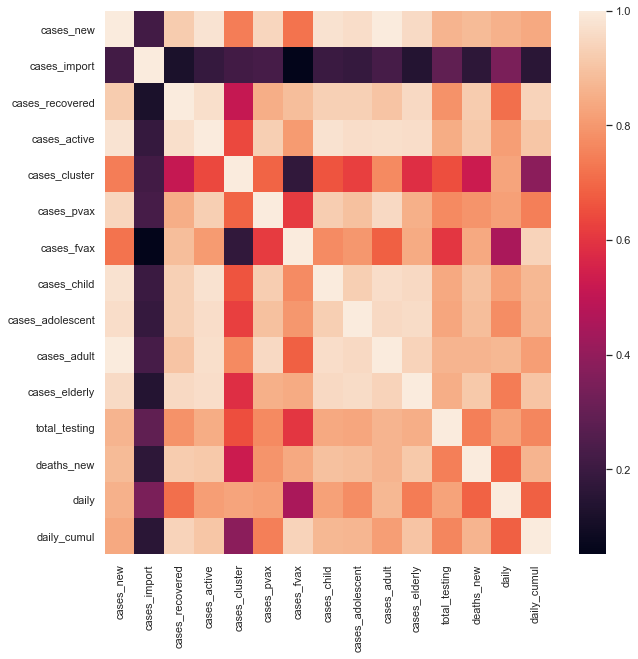

In [1216]:
plt.figure(figsize=(10,10))
cases_testing_deaths_vax = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax = cases_testing_deaths_vax.merge(vax_malaysia[['date', 'daily']], on='date')
cases_testing_deaths_vax['daily_cumul'] = cases_testing_deaths_vax['daily'].cumsum()
sns.heatmap(cases_testing_deaths_vax.corr())

Select best features using Boruta

In [1217]:
X = cases_testing_deaths_vax.drop(columns=['date','daily'])
y = cases_testing_deaths_vax['daily_cumul']

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	1
Rejected: 	1
I

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1218]:
# chosen features
accept = X.columns[feat_selector.support_].to_list()
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
# add back date and percentage vaccinated
filtered['daily'] = y
filtered['date'] = cases_testing_deaths_vax['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)

In [1219]:
filtered

,cases_new,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,total_testing,deaths_new,daily_cumul,daily
date,,,,,,,,,,,,,,
2021-02-24,3545.0,3331.0,30572.0,2483.0,0.0,0.0,145.0,84.0,2919.0,173.0,75122.0,12.0,60.0,60
2021-02-25,1924.0,3752.0,28738.0,705.0,0.0,0.0,158.0,72.0,1473.0,155.0,85929.0,13.0,1206.0,1206
2021-02-26,2253.0,3085.0,27903.0,1136.0,0.0,0.0,124.0,75.0,1822.0,173.0,80221.0,10.0,5322.0,5322
2021-02-27,2364.0,3320.0,26937.0,1100.0,0.0,0.0,147.0,100.0,1858.0,162.0,63567.0,10.0,12046.0,12046
2021-02-28,2437.0,3251.0,26118.0,1404.0,0.0,0.0,132.0,83.0,2044.0,113.0,59526.0,9.0,18748.0,18748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,10915.0,15396.0,155499.0,656.0,1306.0,5885.0,1951.0,938.0,6756.0,1166.0,102196.0,109.0,44145505.0,44145505
2021-10-03,9066.0,14454.0,150019.0,388.0,1124.0,4944.0,1700.0,764.0,5348.0,1087.0,97471.0,118.0,44352079.0,44352079
2021-10-04,8075.0,15456.0,142562.0,731.0,1097.0,4287.0,1353.0,641.0,5050.0,948.0,176380.0,76.0,44573891.0,44573891


In [1220]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X = filtered.drop(columns=['daily_cumul'])
y = filtered['daily_cumul']
X_data = X_scaler.fit_transform(X)
Y_data = Y_scaler.fit_transform(y.values.reshape(-1,1))

In [1221]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X_data = []
     y_data = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X_data.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y_data.append(target[indicey])
     return np.array(X_data), np.array(y_data) 

In [1222]:
hist_window = 50
horizon = 50
TRAIN_SPLIT = 175
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [1223]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 13)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
model.summary()
# Fitting the RNN to the Training set
model.fit(x_train, y_train, epochs = 30, batch_size = 32)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50, 100)           45600     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50, 50)            30200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 50, 1)             51        
Total params: 75,851
Trainable params: 75,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 1s 21ms/step - loss: 0.0853 - mean_squared_error: 0.0853
Epoch 2/3

In [1224]:
data_val = X_scaler.fit_transform(X_data[:50])
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = model.predict(val_rescaled)
pred
pred_inverse = Y_scaler.inverse_transform(pred.reshape(-1,1))
pred_inverse

array([[ 7997890.5],
       [15182857. ],
       [21746274. ],
       [27167746. ],
       [31531124. ],
       [33891470. ],
       [34639810. ],
       [34280870. ],
       [33936588. ],
       [33489268. ],
       [32528114. ],
       [31068192. ],
       [28997790. ],
       [26896448. ],
       [25158970. ],
       [23733790. ],
       [22399992. ],
       [20954560. ],
       [19510546. ],
       [18000892. ],
       [16431668. ],
       [14874261. ],
       [13514733. ],
       [13150019. ],
       [13151007. ],
       [12832131. ],
       [12294828. ],
       [11926871. ],
       [11456140. ],
       [11392606. ],
       [11339424. ],
       [11103950. ],
       [10997422. ],
       [10445441. ],
       [10169751. ],
       [10660891. ],
       [11101314. ],
       [11710237. ],
       [12786061. ],
       [13620135. ],
       [14069348. ],
       [14537126. ],
       [14907949. ],
       [15040114. ],
       [16043625. ],
       [16966888. ],
       [18185384. ],
       [18728

In [1225]:
original = Y_scaler.inverse_transform(Y_data[:50].reshape(-1,1))
original

array([[6.000000e+01],
       [1.206000e+03],
       [5.322000e+03],
       [1.204600e+04],
       [1.874800e+04],
       [3.412400e+04],
       [5.579200e+04],
       [7.848500e+04],
       [9.804400e+04],
       [1.123760e+05],
       [1.281540e+05],
       [1.406920e+05],
       [1.678200e+05],
       [1.978040e+05],
       [2.265250e+05],
       [2.530000e+05],
       [2.790430e+05],
       [2.958800e+05],
       [3.059540e+05],
       [3.262390e+05],
       [3.516970e+05],
       [3.725440e+05],
       [3.906430e+05],
       [4.051660e+05],
       [4.189380e+05],
       [4.344330e+05],
       [4.586860e+05],
       [4.878260e+05],
       [5.168870e+05],
       [5.426410e+05],
       [5.593390e+05],
       [5.753720e+05],
       [5.918960e+05],
       [6.269320e+05],
       [6.677120e+05],
       [7.049720e+05],
       [7.472710e+05],
       [7.777110e+05],
       [7.949650e+05],
       [8.099010e+05],
       [8.384710e+05],
       [8.710800e+05],
       [9.019710e+05],
       [9.2

In [1226]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [1227]:
timeseries_evaluation_metrics_func(original, pred_inverse)

Evaluation metric results:-
MSE is : 399196901195872.5
MAE is : 18269689.51
RMSE is : 19979912.4421473
MAPE is : 316932.91021833493
R2 is : -3617.1948504561374



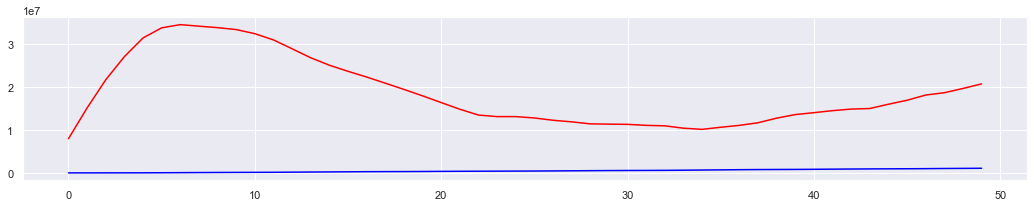

In [1228]:
plt.plot(original, color='blue', label='Original')
plt.plot(pred_inverse, color='red', label='Predicted')

### Is it possible to open schools by November 1 (assume 80% of children in the country are vaccinated)? (Sid)

### Can we predict mortality numbers across the nation? (don't need time series) - Eugene

In [1229]:
dataset1 = pd.read_csv('./cases/epidemic/cases_malaysia.csv')
dataset2 = pd.read_csv('./cases/epidemic/deaths_malaysia.csv')
dataset3 = pd.read_csv('./cases/epidemic/tests_malaysia.csv')
dataset4 = pd.read_csv('./vaccination/vaccination/vax_malaysia.csv') 
total_dataset = dataset1.merge(dataset2, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset3, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset = total_dataset.merge(dataset4, how='inner', on=['date'] )
total_dataset.fillna(0, inplace=True)
total_dataset

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,...,cumul_partial_child,cumul_full_child,pfizer1,pfizer2,sinovac1,sinovac2,astra1,astra2,cansino,pending
0,2021-02-24,3545,1,3331,30572,2483.0,0.0,0.0,145.0,84.0,...,0,0,60,0,0,0,0,0,0,0
1,2021-02-25,1924,6,3752,28738,705.0,0.0,0.0,158.0,72.0,...,0,0,1146,0,0,0,0,0,0,0
2,2021-02-26,2253,7,3085,27903,1136.0,0.0,0.0,124.0,75.0,...,0,0,4115,1,0,0,0,0,0,0
3,2021-02-27,2364,1,3320,26937,1100.0,0.0,0.0,147.0,100.0,...,0,0,6723,1,0,0,0,0,0,0
4,2021-02-28,2437,1,3251,26118,1404.0,0.0,0.0,132.0,83.0,...,0,0,6699,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,2021-10-02,10915,7,15396,155499,656.0,1306.0,5885.0,1951.0,938.0,...,1666131,92949,85634,73484,1907,13712,116,32558,1644,2462
221,2021-10-03,9066,12,14454,150019,388.0,1124.0,4944.0,1700.0,764.0,...,1751834,108826,87792,66883,1907,9508,18,33146,682,6638
222,2021-10-04,8075,6,15456,142562,731.0,1097.0,4287.0,1353.0,641.0,...,1862399,114124,123351,58454,2620,8339,144,26749,1348,807
223,2021-10-05,8817,14,15615,135685,619.0,1062.0,5106.0,1386.0,686.0,...,1967549,120402,119323,59655,2440,13395,130,26496,1828,767


In [1230]:
X = total_dataset.drop(['date','deaths_new'], axis=1)  
y = total_dataset['deaths_new']  

selector = SelectKBest(mutual_info_regression, k=6)
selector.fit(X, y)
mutual_info_best = X.columns[selector.get_support()]

rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
rfe_selector.fit(X, y)
rfe_best = X.columns[rfe_selector.get_support()]

rf = RandomForestRegressor(n_jobs=4, oob_score=True)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
boruta.fit(X.values, y.ravel())
boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]

print(boruta_best)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	11
Rejected: 	23
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	11
Rejected: 	23
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	11
Rejected: 	23
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	11
Rejected: 	23
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	11
Rejected: 	23
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	10
Rejected: 	24
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	10
Rejected: 	24
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	10
Rejected: 	24
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	

In [1231]:
train_model_dataset = total_dataset[boruta_best]
train_model_dataset['deaths_new'] = total_dataset['deaths_new']

In [1232]:
X = train_model_dataset.drop(['deaths_new'], axis=1)  
X = MinMaxScaler().fit_transform(X)
y = train_model_dataset['deaths_new']  
y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 

In [1233]:
regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
regressor.fit(X_train, y_train) 
pred = regressor.predict(X_test)

In [1234]:
mae = round(mean_absolute_error(y_test, pred),4)
mse = round(mean_squared_error(y_test, pred),4)

print('DecisionTreeRegressor MAE: ', mae)
print('DecisionTreeRegressor MSE: ', mse)

DecisionTreeRegressor MAE:  0.0521
DecisionTreeRegressor MSE:  0.01


First of all, we perform feature selection from cases_malaysia.csv, deaths_malaysia.csv, and tests_malaysia.csv datasets by using Boruta in python. After that , the  features that are being selected will be used to train our decision tree regressor model. For our model, it is able to archieve a 0.0521 mean absolute error and a 0.01 mean squared error.

### Can we predict mortality numbers for Melaka, Negeri Sembilan, Perlis, Selangor and W.P. Putrajaya? (don't need time series) - Zhi Hang

In [1235]:
def state_mortality_prediction(state) :
    dataset1 = pd.read_csv('./cases/epidemic/cases_state.csv')
    dataset2 = pd.read_csv('./cases/epidemic/deaths_state.csv')
    dataset3 = pd.read_csv('./cases/epidemic/tests_state.csv')
    dataset4 = pd.read_csv('./vaccination/vaccination/vax_state.csv') 
    total_dataset = dataset1[dataset1['state'] == state].merge(dataset2[dataset2['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset3[dataset3['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    total_dataset = total_dataset.merge(dataset4[dataset4['state'] == state], how='inner', on=['date','state'] )
    total_dataset.fillna(0, inplace=True)
    X = total_dataset.drop(['date','deaths_new','state'], axis=1)  
    y = total_dataset['deaths_new']  

    selector = SelectKBest(mutual_info_regression, k=6)
    selector.fit(X, y)
    mutual_info_best = X.columns[selector.get_support()]

    rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]

    rf = RandomForestRegressor(n_jobs=4, oob_score=True)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
    boruta.fit(X.values, y.ravel())
    boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]
    print(boruta_best)

    return boruta_best,total_dataset

In [1236]:
def get_result(boruta_best , total_dataset) :
    train_model_dataset = total_dataset[boruta_best]
    train_model_dataset['deaths_new'] = total_dataset['deaths_new']
    X = train_model_dataset.drop(['deaths_new'], axis=1)  
    X = MinMaxScaler().fit_transform(X)
    y = train_model_dataset['deaths_new']  
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2) 
    regressor = DecisionTreeRegressor(max_depth=2, criterion="mae", splitter="best")  
    regressor.fit(X_train, y_train) 
    pred = regressor.predict(X_test)
    mae = round(mean_absolute_error(y_test, pred),4)
    mse = round(mean_squared_error(y_test, pred),4)

    print('DecisionTreeRegressor MAE: ', mae)
    print('DecisionTreeRegressor MSE: ', mse)

In [1237]:
boruta_best_Melaka , total_dataset_Melaka = state_mortality_prediction('Melaka')
boruta_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan = state_mortality_prediction('Negeri Sembilan')
boruta_best_Perlis , total_dataset_Perlis = state_mortality_prediction('Perlis')
boruta_best_Selangor , total_dataset_Selangor = state_mortality_prediction('Selangor')
boruta_best_WP_Putrajaya , total_dataset_WP_Putrajaya = state_mortality_prediction('W.P. Putrajaya')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	33
I

In [1238]:
print("Melaka")
get_result(boruta_best_Melaka , total_dataset_Melaka)
print("")
print("Negeri Sembilan")
get_result(boruta_best_Negeri_Sembilan , total_dataset_Negeri_Sembilan)
print("")
print("Perlis")
get_result(boruta_best_Perlis , total_dataset_Perlis)
print("")
print("Selangor")
get_result(boruta_best_Selangor , total_dataset_Selangor)
print("")
print("W.P. Putrajaya")
get_result(boruta_best_WP_Putrajaya , total_dataset_WP_Putrajaya)
print("")

Melaka
DecisionTreeRegressor MAE:  0.1111
DecisionTreeRegressor MSE:  0.0205

Negeri Sembilan
DecisionTreeRegressor MAE:  0.1218
DecisionTreeRegressor MSE:  0.0258

Perlis
DecisionTreeRegressor MAE:  0.0833
DecisionTreeRegressor MSE:  0.0292

Selangor
DecisionTreeRegressor MAE:  0.0462
DecisionTreeRegressor MSE:  0.0035

W.P. Putrajaya
DecisionTreeRegressor MAE:  0.0333
DecisionTreeRegressor MSE:  0.0167



For these questions, we used boruta for the features selection part and the datasets involved are cases_state.csv, deaths_state.csv, tests_state.csv, and vax_state.csv. After the features are selected, we will use the features in our decision tree regressor model to perform the prediction. Based on our results, W.P Putrajaya scored the lowest value in the mean square error which is only 0.333 and Selangor scored the lowest value in the mean squared error result.

## Classification

### Can we classify individual location check-ins in Malaysia using other variables (Low, Medium or High)?

In [1239]:
checkins

,date,checkins,unique_ind,unique_loc
0,2020-12-01,17492265,6614474,630363
1,2020-12-02,17695726,6667261,648752
2,2020-12-03,17063123,6549583,645604
3,2020-12-04,18350879,6803979,622383
4,2020-12-05,19711082,6845366,573132
...,...,...,...,...
307,2021-10-04,28597344,10713530,875488
308,2021-10-05,28991261,10785507,887285
309,2021-10-06,28902108,10762592,889917
310,2021-10-07,29221297,10867785,892105


<AxesSubplot:>

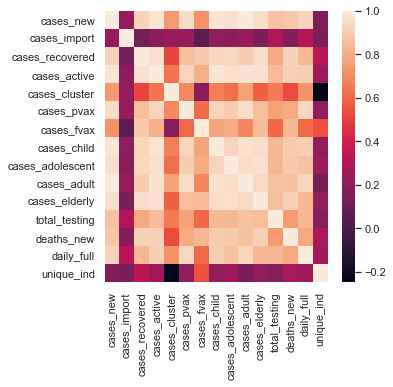

In [1240]:
cases_testing_deaths_vax_checkins = cases_malaysia.merge(tests_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(deaths_malaysia, on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(vax_malaysia[['date', 'daily_full']], on='date')
cases_testing_deaths_vax_checkins = cases_testing_deaths_vax_checkins.merge(checkins[['date', 'unique_ind']], on='date')
plt.figure(figsize=(5,5))
sns.heatmap(cases_testing_deaths_vax_checkins.corr())

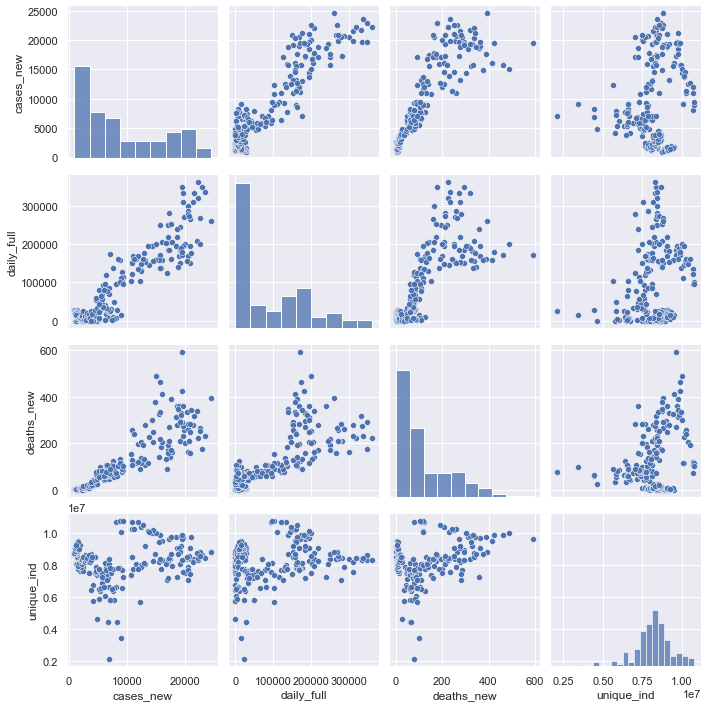

In [1241]:
sns.pairplot(cases_testing_deaths_vax_checkins, vars=['cases_new','daily_full','deaths_new','unique_ind'])

In [1242]:
cases_testing_deaths_vax_checkins['unique_ind'].max()
cases_testing_deaths_vax_checkins['ind_checkins_class'] = pd.cut(cases_testing_deaths_vax_checkins['unique_ind'], 3, labels=['Low', 'Medium', 'High'])
cases_testing_deaths_vax_checkins.drop(['unique_ind'], axis=1, inplace=True)

In [1243]:
from sklearn.ensemble import RandomForestClassifier

X = cases_testing_deaths_vax_checkins.drop(columns=['date', 'ind_checkins_class'])
y = cases_testing_deaths_vax_checkins['ind_checkins_class']

rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X.values, y.ravel())

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0
I

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1244]:
# chosen features
accept = X.columns[feat_selector.support_].to_list()
# transform dataframe to only selected features
filtered = pd.DataFrame(feat_selector.transform(X.values), columns=accept)
# add back date and percentage vaccinated
filtered['ind_checkins_class'] = y
filtered['date'] = cases_testing_deaths_vax_checkins['date']
filtered['date'] = pd.to_datetime(filtered['date'])
filtered.set_index('date', inplace=True)
filtered

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,total_testing,deaths_new,daily_full,ind_checkins_class
date,,,,,,,,,,,,,,,
2021-02-24,3545.0,1.0,3331.0,30572.0,2483.0,0.0,0.0,145.0,84.0,2919.0,173.0,75122.0,12.0,0.0,Medium
2021-02-25,1924.0,6.0,3752.0,28738.0,705.0,0.0,0.0,158.0,72.0,1473.0,155.0,85929.0,13.0,0.0,Medium
2021-02-26,2253.0,7.0,3085.0,27903.0,1136.0,0.0,0.0,124.0,75.0,1822.0,173.0,80221.0,10.0,1.0,Medium
2021-02-27,2364.0,1.0,3320.0,26937.0,1100.0,0.0,0.0,147.0,100.0,1858.0,162.0,63567.0,10.0,1.0,Medium
2021-02-28,2437.0,1.0,3251.0,26118.0,1404.0,0.0,0.0,132.0,83.0,2044.0,113.0,59526.0,9.0,3.0,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02,10915.0,7.0,15396.0,155499.0,656.0,1306.0,5885.0,1951.0,938.0,6756.0,1166.0,102196.0,109.0,121822.0,High
2021-10-03,9066.0,12.0,14454.0,150019.0,388.0,1124.0,4944.0,1700.0,764.0,5348.0,1087.0,97471.0,118.0,110550.0,High
2021-10-04,8075.0,6.0,15456.0,142562.0,731.0,1097.0,4287.0,1353.0,641.0,5050.0,948.0,176380.0,76.0,95379.0,High


In [1245]:
from imblearn.over_sampling import SMOTE
# import train_test_split
from sklearn.model_selection import train_test_split
# SMOTE dataset
X = filtered.drop(columns=['ind_checkins_class'])
y = filtered['ind_checkins_class']
smt = SMOTE(random_state=42, k_neighbors=3)
X_smt, y_smt = smt.fit_resample(X, y)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.2, random_state=42)

ModuleNotFoundError: No module named 'imblearn'

#### Random Forest Classifier

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, y_train)
# get score
rf.score(X_test, y_test)

0.9080459770114943

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test, y_test)

0.7471264367816092

#### Naive Bayes Classifier

In [ ]:
# import naive bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.6091954022988506